In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [8]:
# Load datasets
sales = pd.read_csv('/kaggle/input/forecasting-data/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/forecasting-data/calendar.csv')
prices = pd.read_csv('/kaggle/input/forecasting-data/sell_prices.csv')

print(f"Sales data shape: {sales.shape}")
print(f"Calendar data shape: {calendar.shape}")
print(f"Prices data shape: {prices.shape}")

Sales data shape: (30490, 1919)
Calendar data shape: (1969, 14)
Prices data shape: (6841121, 4)


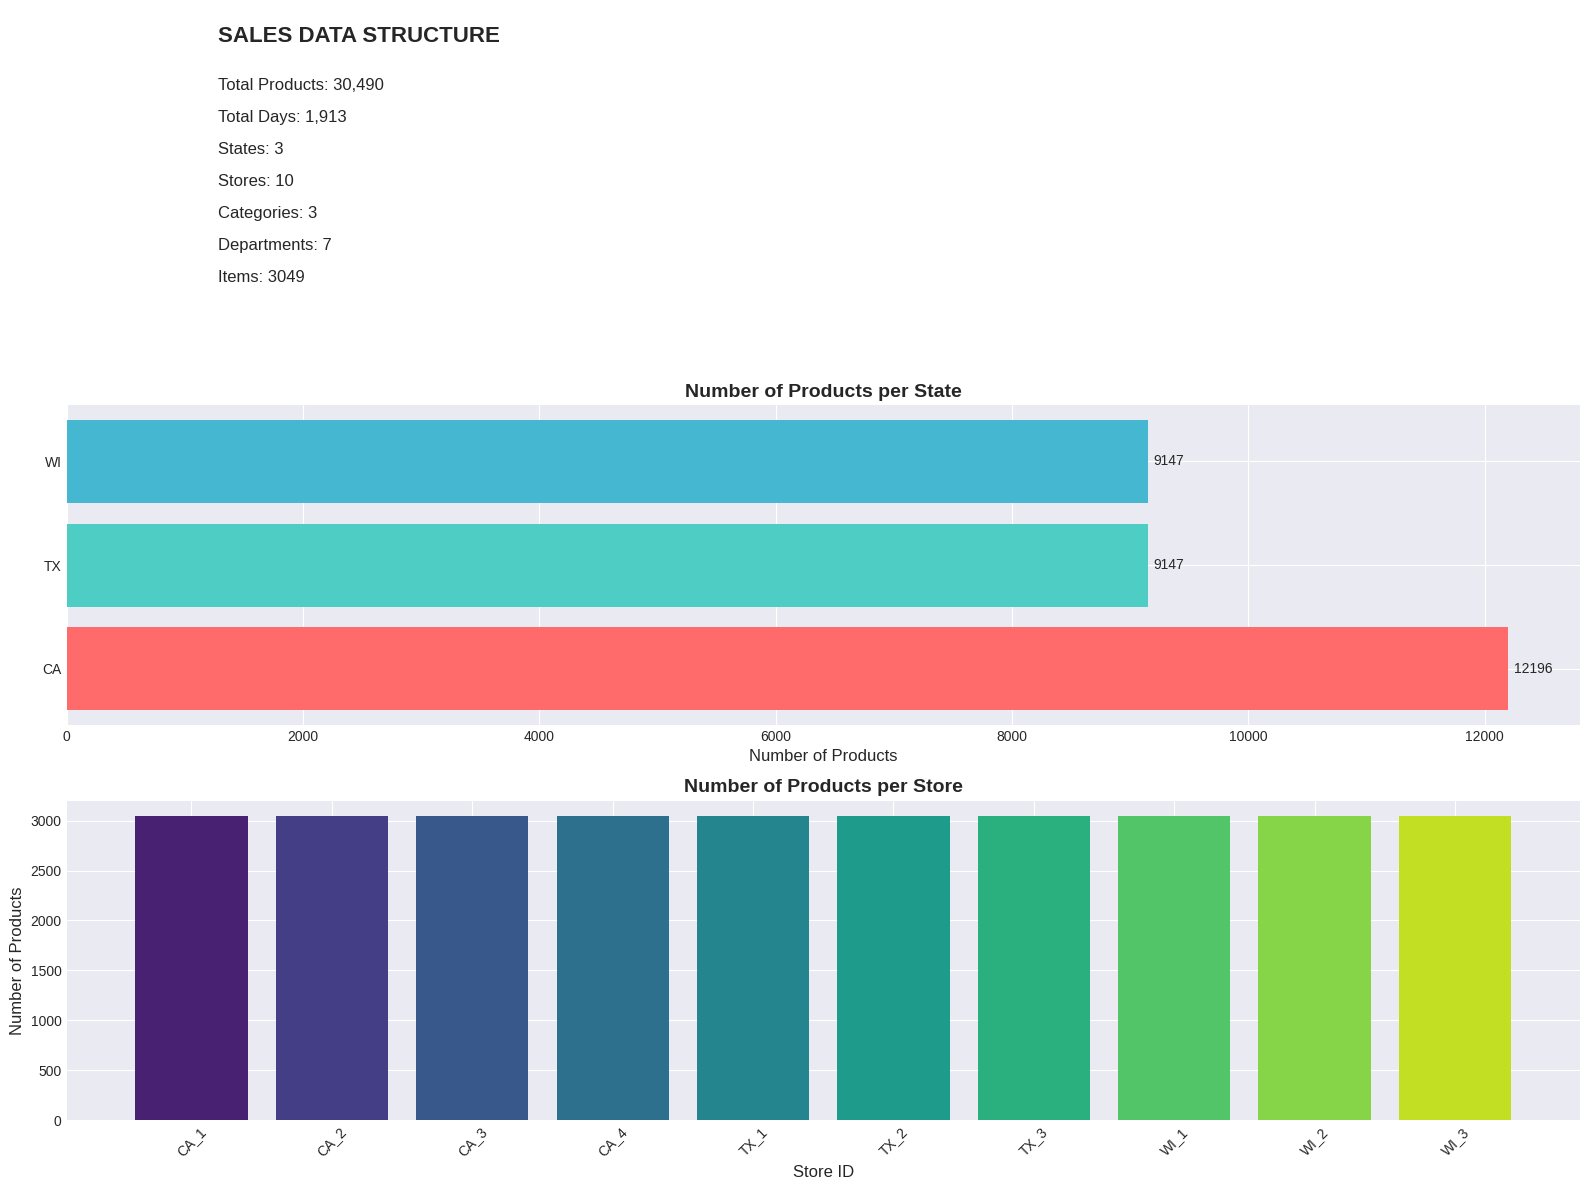

In [10]:
print("\n[2/12] Basic Data Overview...")
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Sales data structure
axes[0].text(0.1, 0.9, "SALES DATA STRUCTURE", fontsize=16, weight='bold', transform=axes[0].transAxes)
axes[0].text(0.1, 0.75, f"Total Products: {sales.shape[0]:,}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.65, f"Total Days: {len([col for col in sales.columns if col.startswith('d_')]):,}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.55, f"States: {sales['state_id'].nunique()}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.45, f"Stores: {sales['store_id'].nunique()}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.35, f"Categories: {sales['cat_id'].nunique()}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.25, f"Departments: {sales['dept_id'].nunique()}", fontsize=12, transform=axes[0].transAxes)
axes[0].text(0.1, 0.15, f"Items: {sales['item_id'].nunique()}", fontsize=12, transform=axes[0].transAxes)
axes[0].axis('off')

# Hierarchical breakdown
state_counts = sales['state_id'].value_counts()
axes[1].barh(state_counts.index, state_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Number of Products per State', fontsize=14, weight='bold')
axes[1].set_xlabel('Number of Products', fontsize=12)
for i, v in enumerate(state_counts.values):
    axes[1].text(v + 50, i, str(v), va='center')

# Store breakdown
store_counts = sales['store_id'].value_counts().sort_index()
axes[2].bar(range(len(store_counts)), store_counts.values, color=sns.color_palette("viridis", len(store_counts)))
axes[2].set_title('Number of Products per Store', fontsize=14, weight='bold')
axes[2].set_xlabel('Store ID', fontsize=12)
axes[2].set_ylabel('Number of Products', fontsize=12)
axes[2].set_xticks(range(len(store_counts)))
axes[2].set_xticklabels(store_counts.index, rotation=45)

plt.tight_layout()
plt.savefig('01_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()


[3/12] Analyzing Categories and Departments...


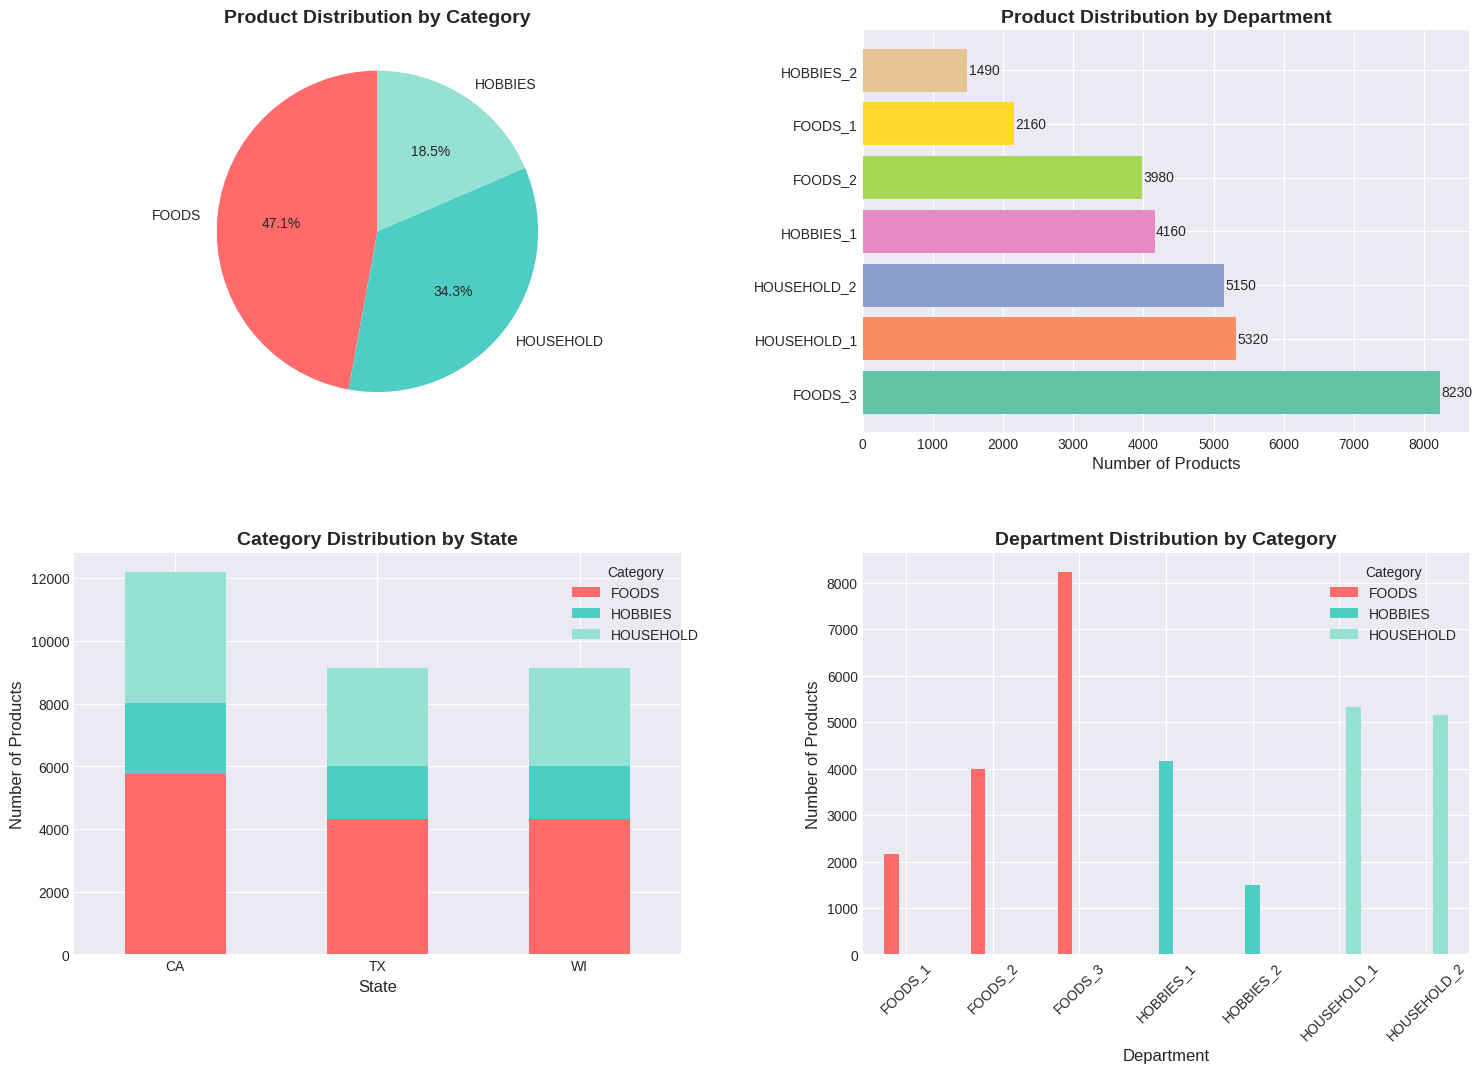

In [13]:
print("\n[3/12] Analyzing Categories and Departments...")
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Category distribution
cat_counts = sales['cat_id'].value_counts()
ax1.pie(cat_counts.values, labels=cat_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax1.set_title('Product Distribution by Category', fontsize=14, weight='bold')

# Department distribution
dept_counts = sales['dept_id'].value_counts()
colors_dept = sns.color_palette("Set2", len(dept_counts))
ax2.barh(dept_counts.index, dept_counts.values, color=colors_dept)
ax2.set_title('Product Distribution by Department', fontsize=14, weight='bold')
ax2.set_xlabel('Number of Products', fontsize=12)
for i, v in enumerate(dept_counts.values):
    ax2.text(v + 20, i, str(v), va='center')

# Category by State
cat_state = sales.groupby(['state_id', 'cat_id']).size().unstack(fill_value=0)
cat_state.plot(kind='bar', stacked=True, ax=ax3, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax3.set_title('Category Distribution by State', fontsize=14, weight='bold')
ax3.set_xlabel('State', fontsize=12)
ax3.set_ylabel('Number of Products', fontsize=12)
ax3.legend(title='Category', bbox_to_anchor=(1.05, 1))
ax3.tick_params(axis='x', rotation=0)

# Department by Category
dept_cat = sales.groupby(['cat_id', 'dept_id']).size().unstack(fill_value=0).T
dept_cat.plot(kind='bar', ax=ax4, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
ax4.set_title('Department Distribution by Category', fontsize=14, weight='bold')
ax4.set_xlabel('Department', fontsize=12)
ax4.set_ylabel('Number of Products', fontsize=12)
ax4.legend(title='Category')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('02_category_department_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


[4/12] Analyzing Aggregate Time Series...


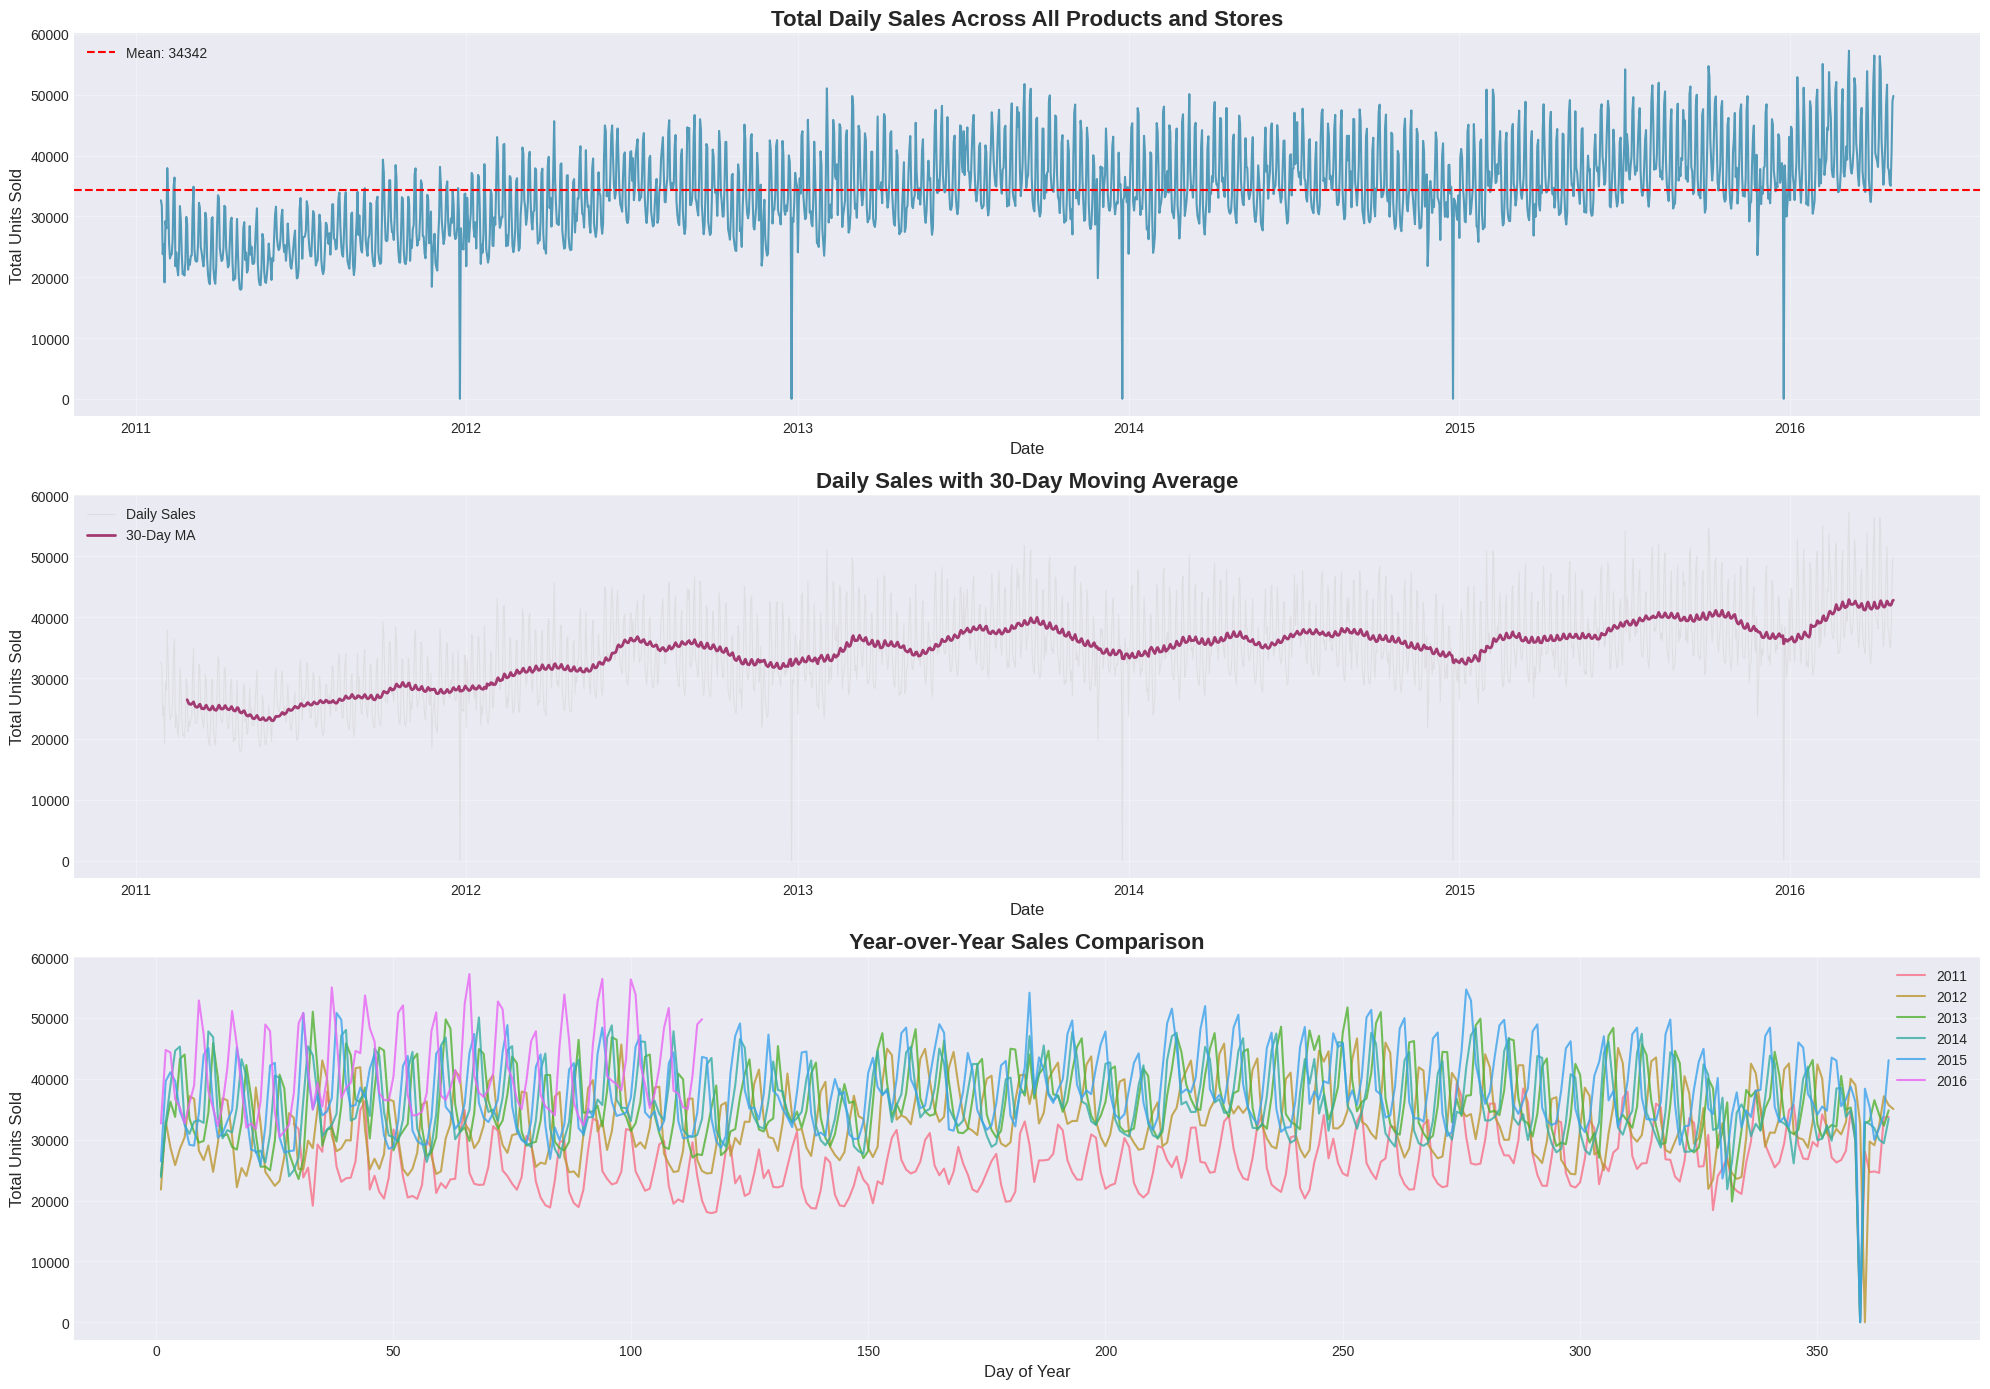

In [14]:
print("\n[4/12] Analyzing Aggregate Time Series...")

# Extract day columns
day_cols = [col for col in sales.columns if col.startswith('d_')]

# Calculate total daily sales
daily_sales = sales[day_cols].sum(axis=0).values
dates = pd.to_datetime(calendar['date'].values[:len(daily_sales)])

fig, axes = plt.subplots(3, 1, figsize=(20, 14))

# Overall sales trend
axes[0].plot(dates, daily_sales, linewidth=1.5, color='#2E86AB', alpha=0.8)
axes[0].set_title('Total Daily Sales Across All Products and Stores', fontsize=16, weight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Total Units Sold', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=daily_sales.mean(), color='red', linestyle='--', label=f'Mean: {daily_sales.mean():.0f}')
axes[0].legend()

# 30-day moving average
ma_30 = pd.Series(daily_sales).rolling(window=30).mean()
axes[1].plot(dates, daily_sales, linewidth=0.8, alpha=0.5, label='Daily Sales', color='lightgray')
axes[1].plot(dates, ma_30, linewidth=2, label='30-Day MA', color='#A23B72')
axes[1].set_title('Daily Sales with 30-Day Moving Average', fontsize=16, weight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Total Units Sold', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Year-over-year comparison
sales_df = pd.DataFrame({'date': dates, 'sales': daily_sales})
sales_df['year'] = sales_df['date'].dt.year
sales_df['dayofyear'] = sales_df['date'].dt.dayofyear

for year in sales_df['year'].unique():
    year_data = sales_df[sales_df['year'] == year]
    axes[2].plot(year_data['dayofyear'], year_data['sales'], 
                label=f'{year}', linewidth=1.5, alpha=0.8)

axes[2].set_title('Year-over-Year Sales Comparison', fontsize=16, weight='bold')
axes[2].set_xlabel('Day of Year', fontsize=12)
axes[2].set_ylabel('Total Units Sold', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_aggregate_sales_trends.png', dpi=300, bbox_inches='tight')
plt.show()


[5/12] Analyzing Sales by State...


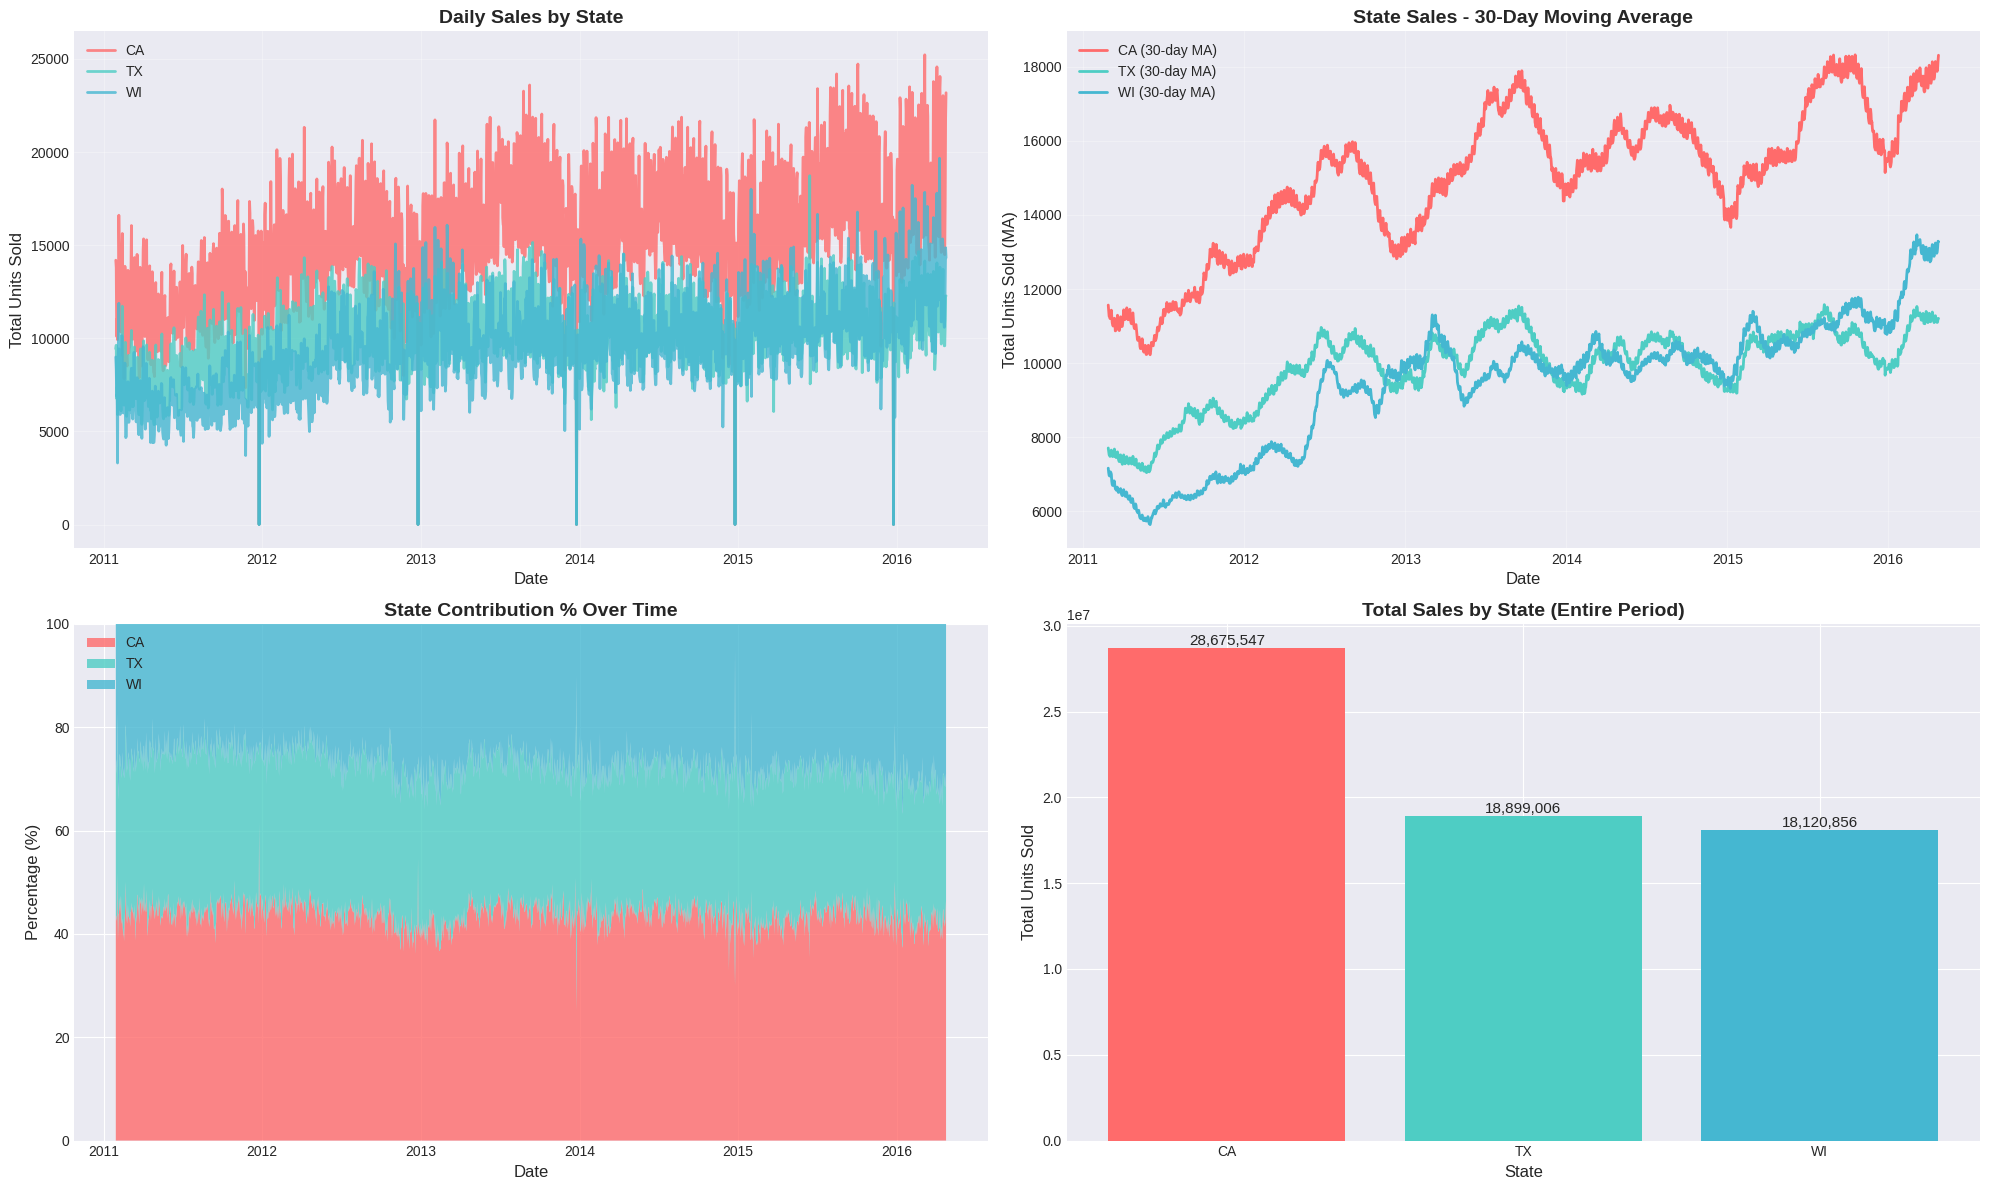

In [15]:
print("\n[5/12] Analyzing Sales by State...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

states = sales['state_id'].unique()
colors_state = {'CA': '#FF6B6B', 'TX': '#4ECDC4', 'WI': '#45B7D1'}

# Sales trend by state
for state in states:
    state_sales = sales[sales['state_id'] == state][day_cols].sum(axis=0).values
    axes[0, 0].plot(dates, state_sales, label=state, linewidth=2, 
                    color=colors_state[state], alpha=0.8)

axes[0, 0].set_title('Daily Sales by State', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# State sales with moving average
for state in states:
    state_sales = sales[sales['state_id'] == state][day_cols].sum(axis=0).values
    ma = pd.Series(state_sales).rolling(window=30).mean()
    axes[0, 1].plot(dates, ma, label=f'{state} (30-day MA)', 
                    linewidth=2, color=colors_state[state])

axes[0, 1].set_title('State Sales - 30-Day Moving Average', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Total Units Sold (MA)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# State contribution percentage over time
state_pct = pd.DataFrame()
for state in states:
    state_sales = sales[sales['state_id'] == state][day_cols].sum(axis=0).values
    state_pct[state] = (state_sales / daily_sales) * 100

axes[1, 0].stackplot(dates, state_pct['CA'], state_pct['TX'], state_pct['WI'],
                     labels=states, colors=[colors_state[s] for s in states], alpha=0.8)
axes[1, 0].set_title('State Contribution % Over Time', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Percentage (%)', fontsize=12)
axes[1, 0].legend(loc='upper left')
axes[1, 0].set_ylim(0, 100)

# Total sales by state - Bar chart
state_total_sales = sales.groupby('state_id')[day_cols].sum().sum(axis=1)
axes[1, 1].bar(state_total_sales.index, state_total_sales.values, 
               color=[colors_state[s] for s in state_total_sales.index])
axes[1, 1].set_title('Total Sales by State (Entire Period)', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('State', fontsize=12)
axes[1, 1].set_ylabel('Total Units Sold', fontsize=12)
for i, v in enumerate(state_total_sales.values):
    axes[1, 1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('04_sales_by_state.png', dpi=300, bbox_inches='tight')
plt.show()


[6/12] Analyzing Sales by Category...


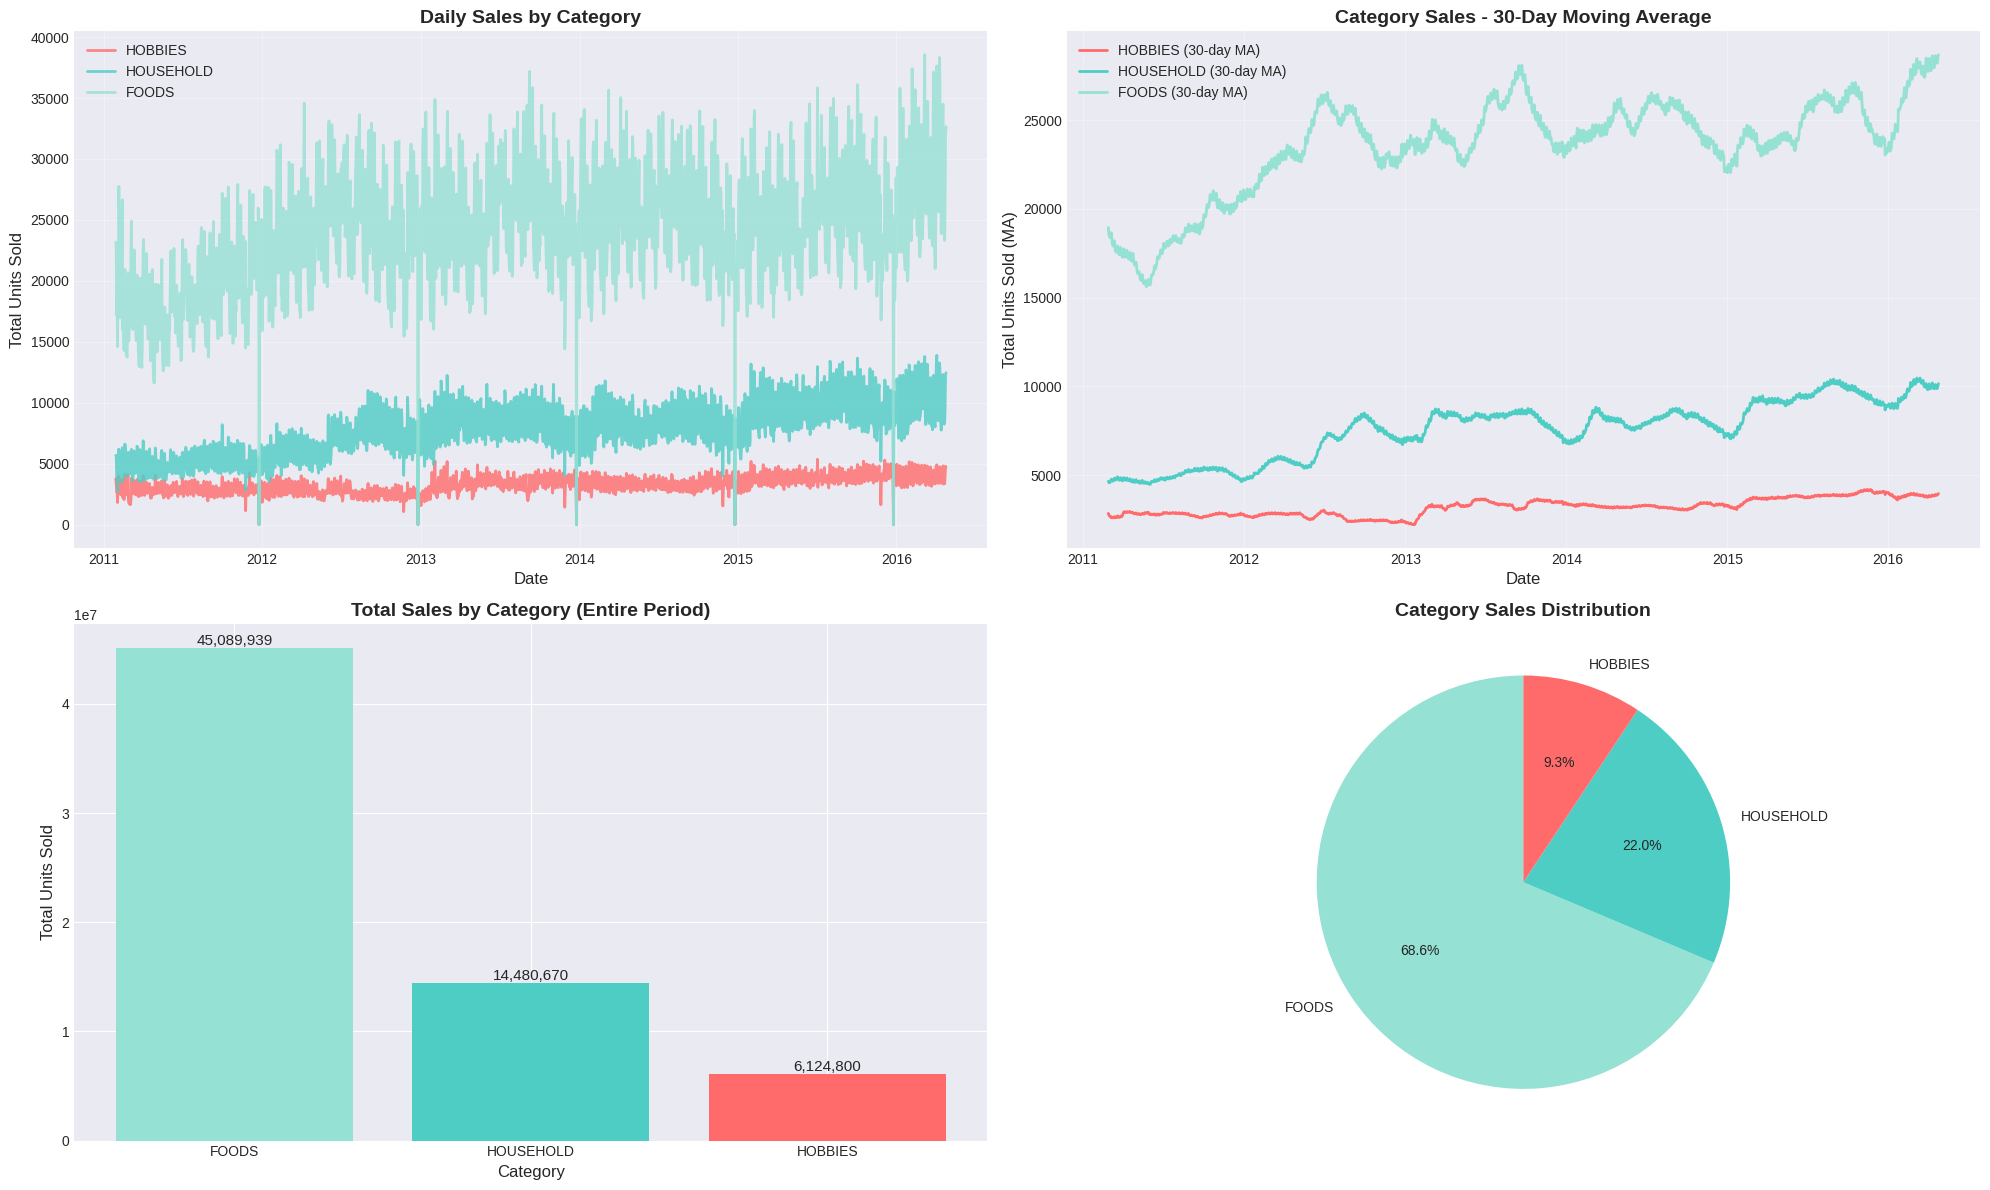

In [16]:
print("\n[6/12] Analyzing Sales by Category...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

categories = sales['cat_id'].unique()
colors_cat = {'HOBBIES': '#FF6B6B', 'HOUSEHOLD': '#4ECDC4', 'FOODS': '#95E1D3'}

# Sales trend by category
for cat in categories:
    cat_sales = sales[sales['cat_id'] == cat][day_cols].sum(axis=0).values
    axes[0, 0].plot(dates, cat_sales, label=cat, linewidth=2, 
                    color=colors_cat[cat], alpha=0.8)

axes[0, 0].set_title('Daily Sales by Category', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Category sales with moving average
for cat in categories:
    cat_sales = sales[sales['cat_id'] == cat][day_cols].sum(axis=0).values
    ma = pd.Series(cat_sales).rolling(window=30).mean()
    axes[0, 1].plot(dates, ma, label=f'{cat} (30-day MA)', 
                    linewidth=2, color=colors_cat[cat])

axes[0, 1].set_title('Category Sales - 30-Day Moving Average', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Total Units Sold (MA)', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Total sales by category
cat_total_sales = sales.groupby('cat_id')[day_cols].sum().sum(axis=1).sort_values(ascending=False)
axes[1, 0].bar(range(len(cat_total_sales)), cat_total_sales.values, 
               color=[colors_cat[c] for c in cat_total_sales.index])
axes[1, 0].set_title('Total Sales by Category (Entire Period)', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Category', fontsize=12)
axes[1, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[1, 0].set_xticks(range(len(cat_total_sales)))
axes[1, 0].set_xticklabels(cat_total_sales.index)
for i, v in enumerate(cat_total_sales.values):
    axes[1, 0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=11)

# Category contribution pie chart
axes[1, 1].pie(cat_total_sales.values, labels=cat_total_sales.index, autopct='%1.1f%%',
               startangle=90, colors=[colors_cat[c] for c in cat_total_sales.index])
axes[1, 1].set_title('Category Sales Distribution', fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig('05_sales_by_category.png', dpi=300, bbox_inches='tight')
plt.show()


[7/12] Analyzing Sales by Store...


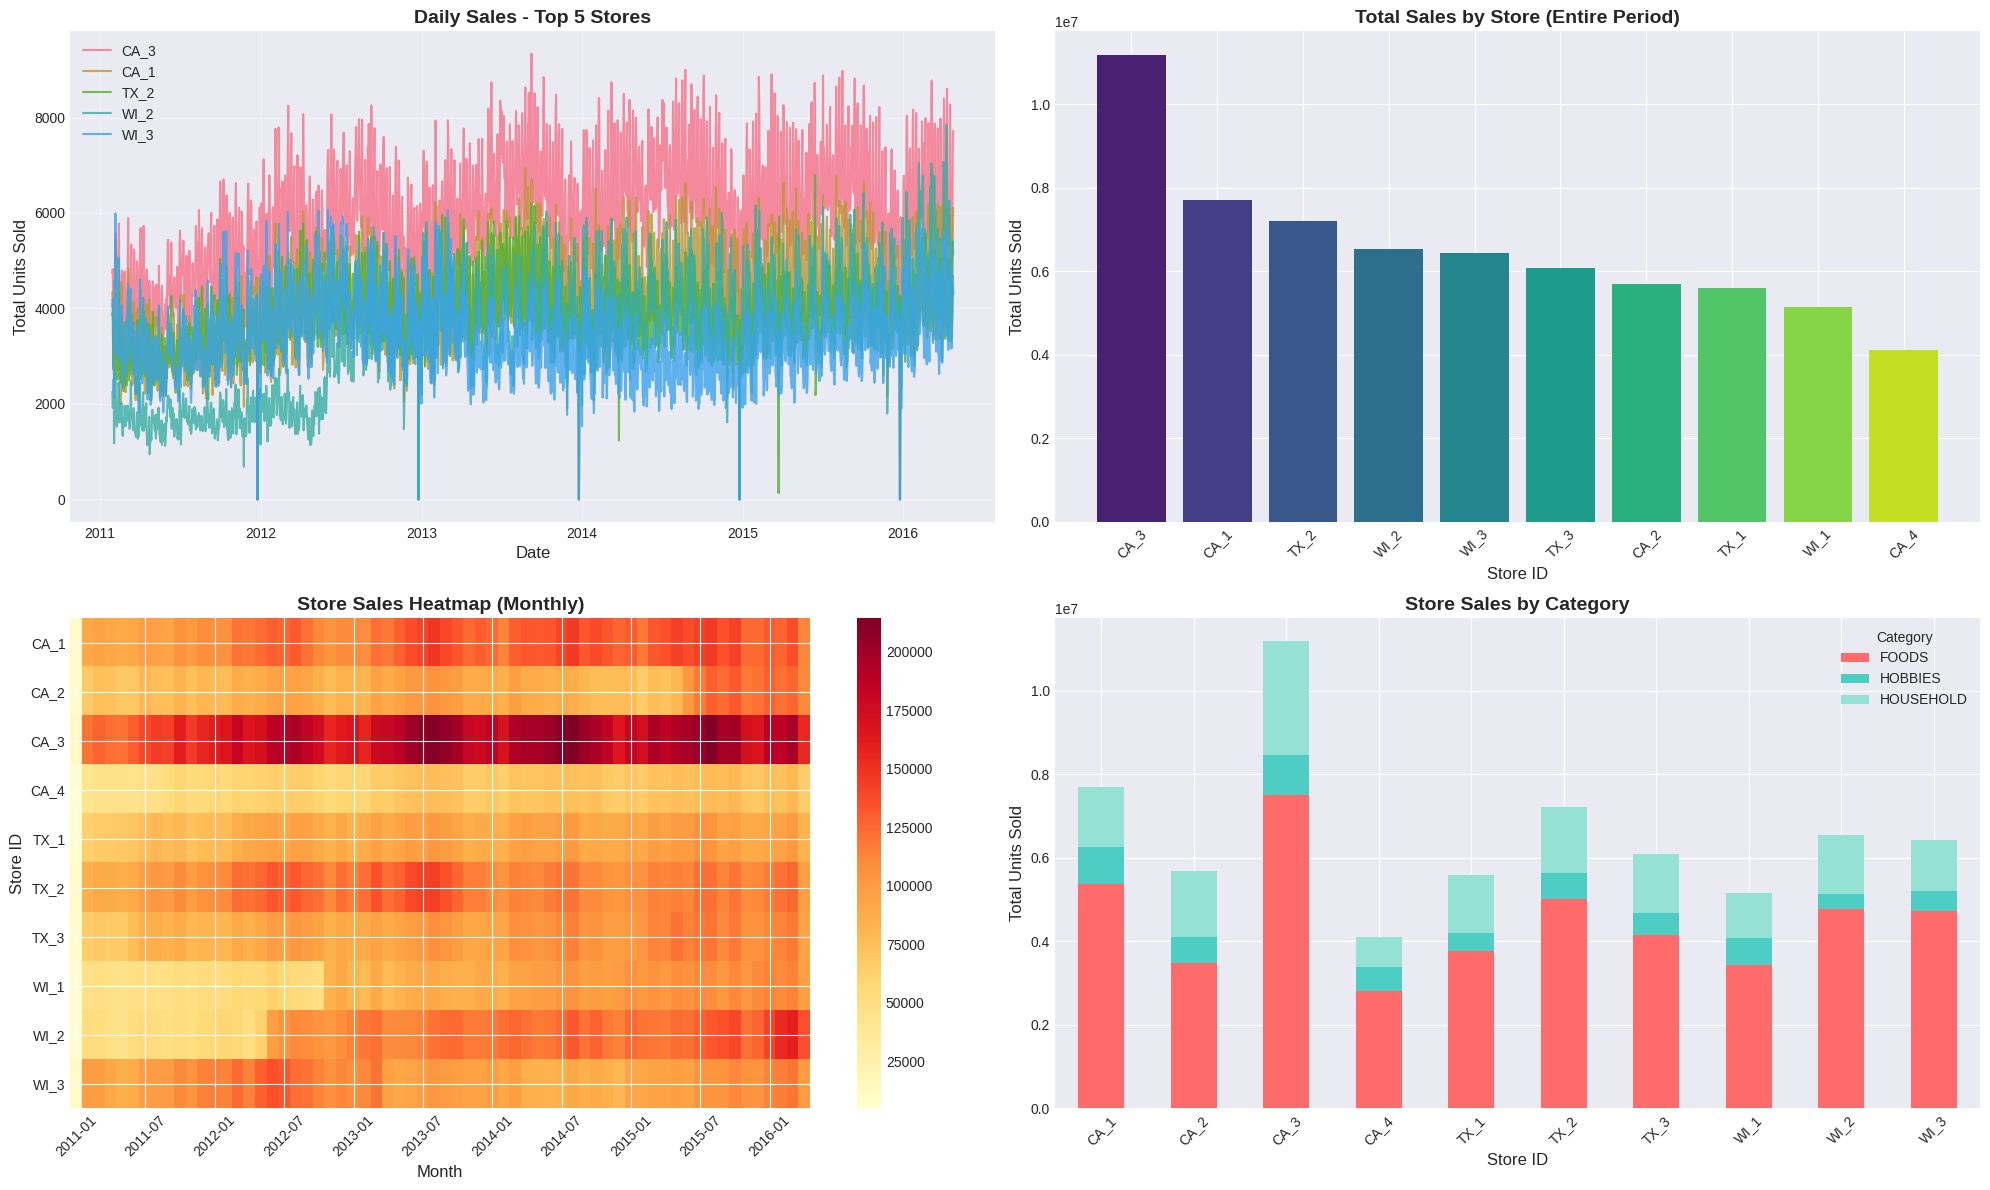

In [17]:
print("\n[7/12] Analyzing Sales by Store...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

stores = sorted(sales['store_id'].unique())

# Store sales comparison - Line plot (top 5 stores)
store_sales_total = sales.groupby('store_id')[day_cols].sum().sum(axis=1).sort_values(ascending=False)
top_stores = store_sales_total.head(5).index

for store in top_stores:
    store_sales = sales[sales['store_id'] == store][day_cols].sum(axis=0).values
    axes[0, 0].plot(dates, store_sales, label=store, linewidth=1.5, alpha=0.8)

axes[0, 0].set_title('Daily Sales - Top 5 Stores', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# All stores - Total sales bar chart
axes[0, 1].bar(range(len(store_sales_total)), store_sales_total.values, 
               color=sns.color_palette("viridis", len(store_sales_total)))
axes[0, 1].set_title('Total Sales by Store (Entire Period)', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Store ID', fontsize=12)
axes[0, 1].set_ylabel('Total Units Sold', fontsize=12)
axes[0, 1].set_xticks(range(len(store_sales_total)))
axes[0, 1].set_xticklabels(store_sales_total.index, rotation=45)

# Store sales heatmap over time (monthly aggregation)
sales_monthly = pd.DataFrame()
sales_monthly['date'] = dates
for store in stores:
    sales_monthly[store] = sales[sales['store_id'] == store][day_cols].sum(axis=0).values

sales_monthly['year_month'] = sales_monthly['date'].dt.to_period('M')
monthly_pivot = sales_monthly.groupby('year_month')[stores].sum()

im = axes[1, 0].imshow(monthly_pivot.T.values, aspect='auto', cmap='YlOrRd')
axes[1, 0].set_title('Store Sales Heatmap (Monthly)', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Store ID', fontsize=12)
axes[1, 0].set_yticks(range(len(stores)))
axes[1, 0].set_yticklabels(stores)
axes[1, 0].set_xticks(range(0, len(monthly_pivot), 6))
axes[1, 0].set_xticklabels([str(monthly_pivot.index[i]) for i in range(0, len(monthly_pivot), 6)], rotation=45)
plt.colorbar(im, ax=axes[1, 0])

# Store sales by category
store_cat_sales = sales.groupby(['store_id', 'cat_id'])[day_cols].sum().sum(axis=1).unstack(fill_value=0)
store_cat_sales.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                     color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[1, 1].set_title('Store Sales by Category', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Store ID', fontsize=12)
axes[1, 1].set_ylabel('Total Units Sold', fontsize=12)
axes[1, 1].legend(title='Category')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('06_sales_by_store.png', dpi=300, bbox_inches='tight')
plt.show()


[8/12] Analyzing Seasonality Patterns...


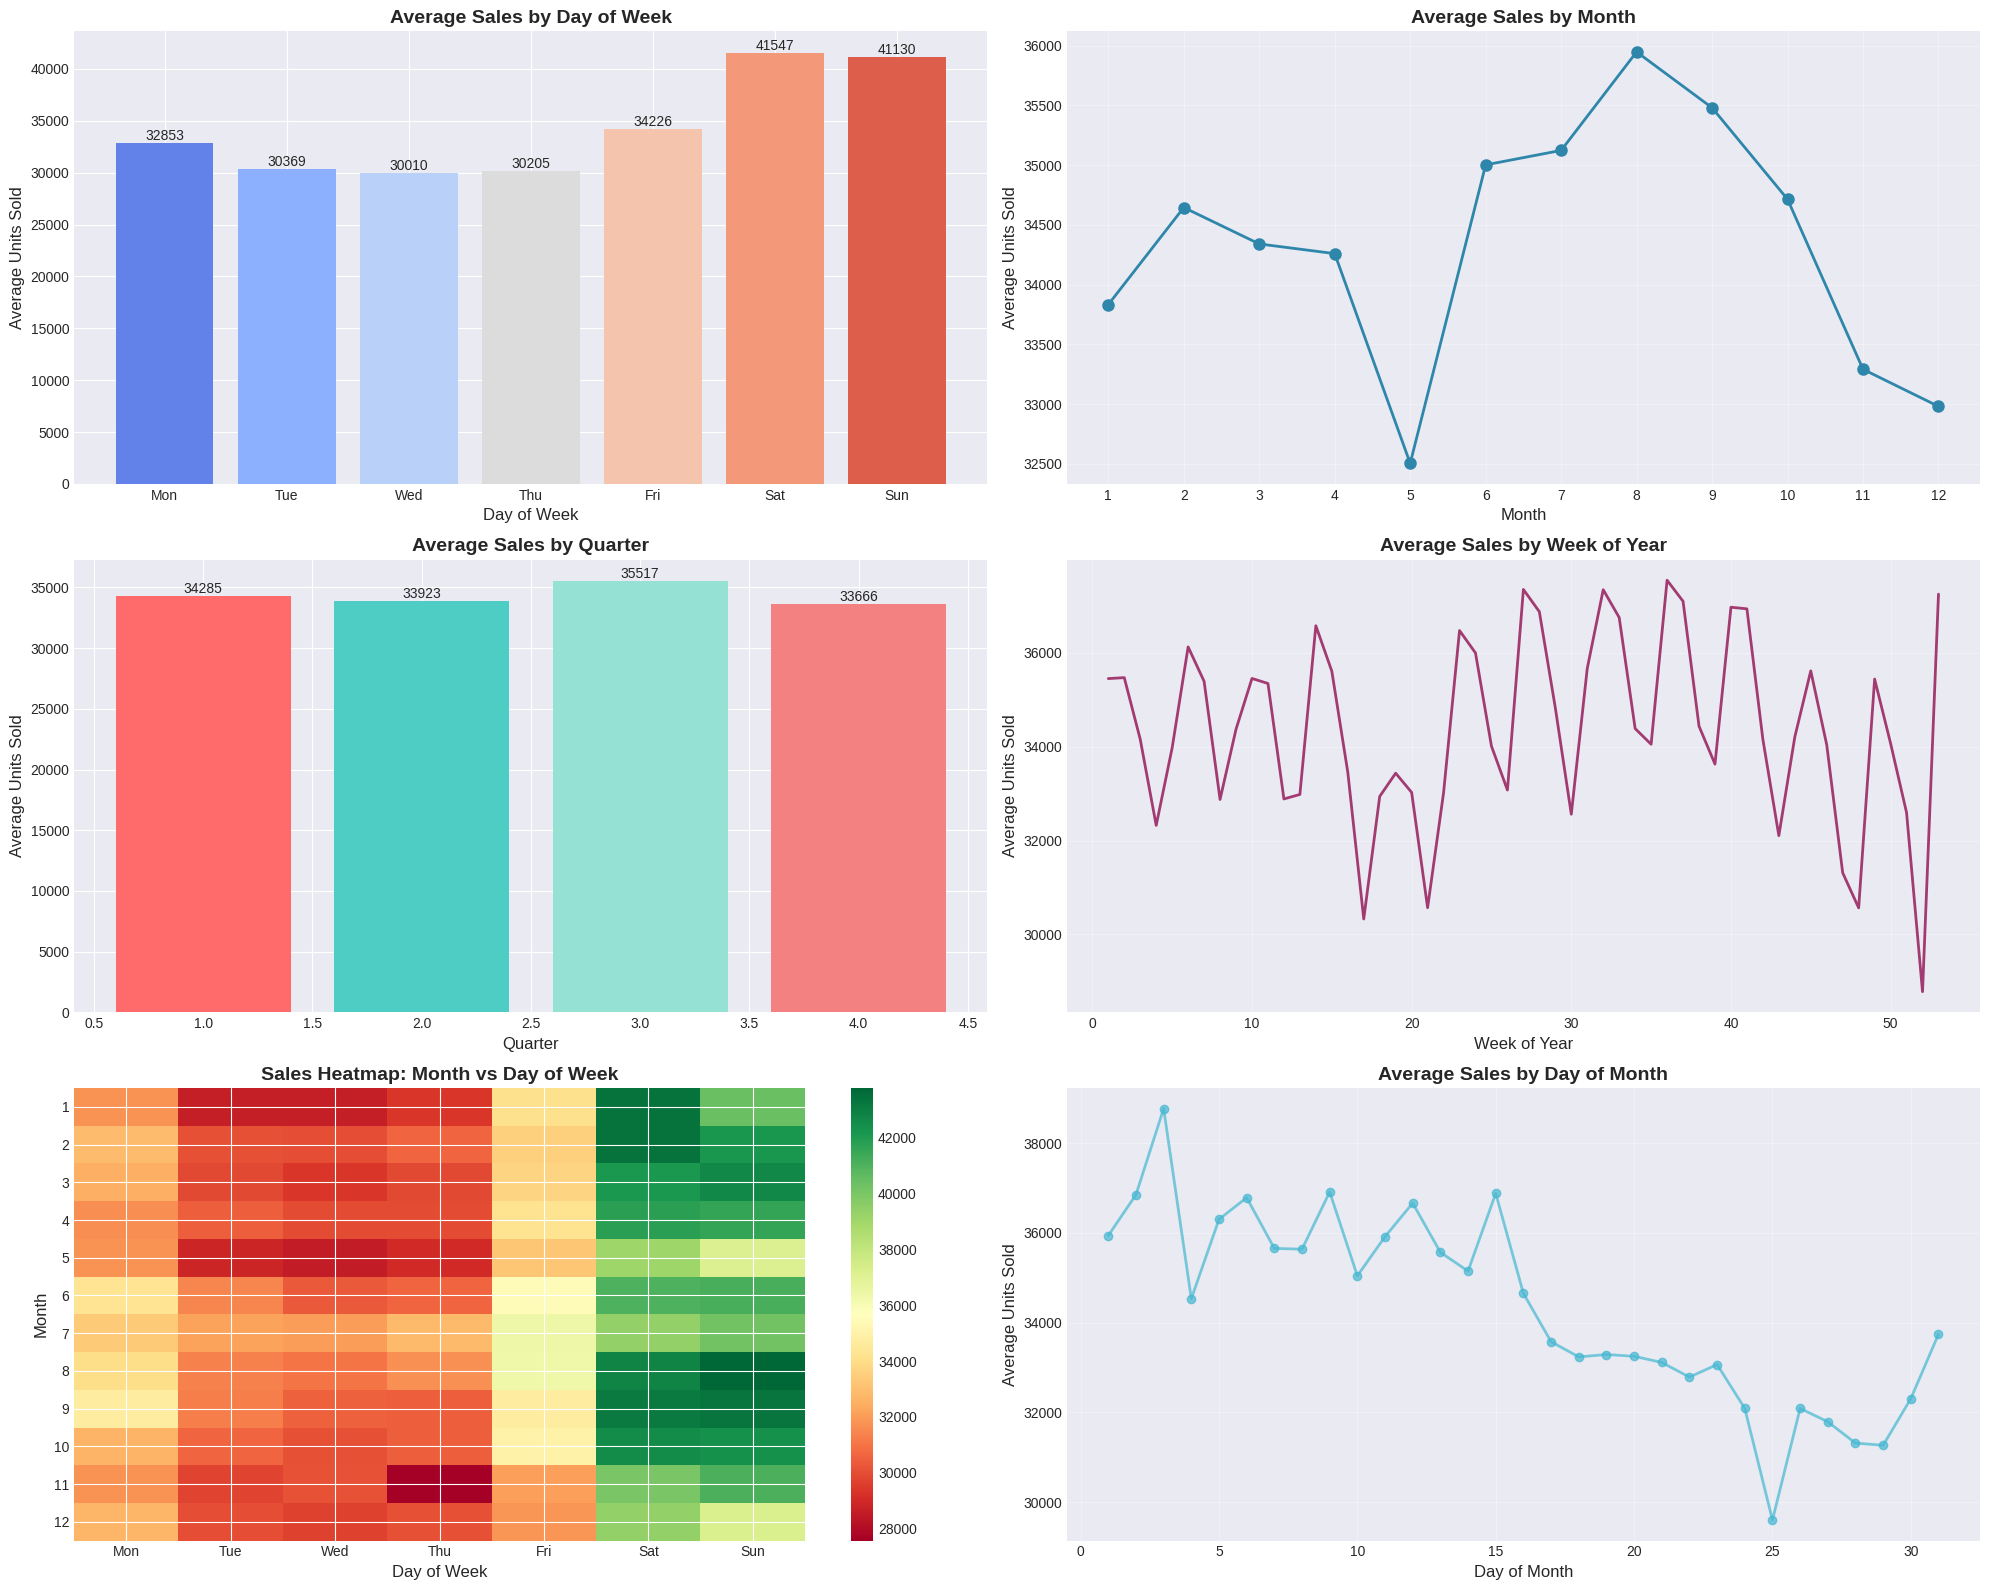

In [18]:
print("\n[8/12] Analyzing Seasonality Patterns...")

sales_df = pd.DataFrame({'date': dates, 'sales': daily_sales})
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day
sales_df['dayofweek'] = sales_df['date'].dt.dayofweek
sales_df['week'] = sales_df['date'].dt.isocalendar().week
sales_df['quarter'] = sales_df['date'].dt.quarter

fig, axes = plt.subplots(3, 2, figsize=(20, 16))

# Day of week pattern
dow_sales = sales_df.groupby('dayofweek')['sales'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 0].bar(range(7), dow_sales.values, color=sns.color_palette("coolwarm", 7))
axes[0, 0].set_title('Average Sales by Day of Week', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Day of Week', fontsize=12)
axes[0, 0].set_ylabel('Average Units Sold', fontsize=12)
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels(dow_labels)
for i, v in enumerate(dow_sales.values):
    axes[0, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# Monthly pattern
month_sales = sales_df.groupby('month')['sales'].mean()
axes[0, 1].plot(month_sales.index, month_sales.values, marker='o', linewidth=2, 
                markersize=8, color='#2E86AB')
axes[0, 1].set_title('Average Sales by Month', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Average Units Sold', fontsize=12)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True, alpha=0.3)

# Quarterly pattern
quarter_sales = sales_df.groupby('quarter')['sales'].mean()
axes[1, 0].bar(quarter_sales.index, quarter_sales.values, 
               color=['#FF6B6B', '#4ECDC4', '#95E1D3', '#F38181'])
axes[1, 0].set_title('Average Sales by Quarter', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Quarter', fontsize=12)
axes[1, 0].set_ylabel('Average Units Sold', fontsize=12)
for i, v in enumerate(quarter_sales.values, 1):
    axes[1, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# Weekly pattern over time
weekly_sales = sales_df.groupby('week')['sales'].mean()
axes[1, 1].plot(weekly_sales.index, weekly_sales.values, linewidth=2, color='#A23B72')
axes[1, 1].set_title('Average Sales by Week of Year', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Week of Year', fontsize=12)
axes[1, 1].set_ylabel('Average Units Sold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

# Heatmap: Day of week vs Month
dow_month_sales = sales_df.groupby(['month', 'dayofweek'])['sales'].mean().unstack()
im = axes[2, 0].imshow(dow_month_sales.values, aspect='auto', cmap='RdYlGn')
axes[2, 0].set_title('Sales Heatmap: Month vs Day of Week', fontsize=14, weight='bold')
axes[2, 0].set_xlabel('Day of Week', fontsize=12)
axes[2, 0].set_ylabel('Month', fontsize=12)
axes[2, 0].set_xticks(range(7))
axes[2, 0].set_xticklabels(dow_labels)
axes[2, 0].set_yticks(range(12))
axes[2, 0].set_yticklabels(range(1, 13))
plt.colorbar(im, ax=axes[2, 0])

# Day of month pattern
day_sales = sales_df.groupby('day')['sales'].mean()
axes[2, 1].plot(day_sales.index, day_sales.values, marker='o', linewidth=2, 
                markersize=6, color='#45B7D1', alpha=0.7)
axes[2, 1].set_title('Average Sales by Day of Month', fontsize=14, weight='bold')
axes[2, 1].set_xlabel('Day of Month', fontsize=12)
axes[2, 1].set_ylabel('Average Units Sold', fontsize=12)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_seasonality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


[9/12] Analyzing Zero Sales and Intermittency...


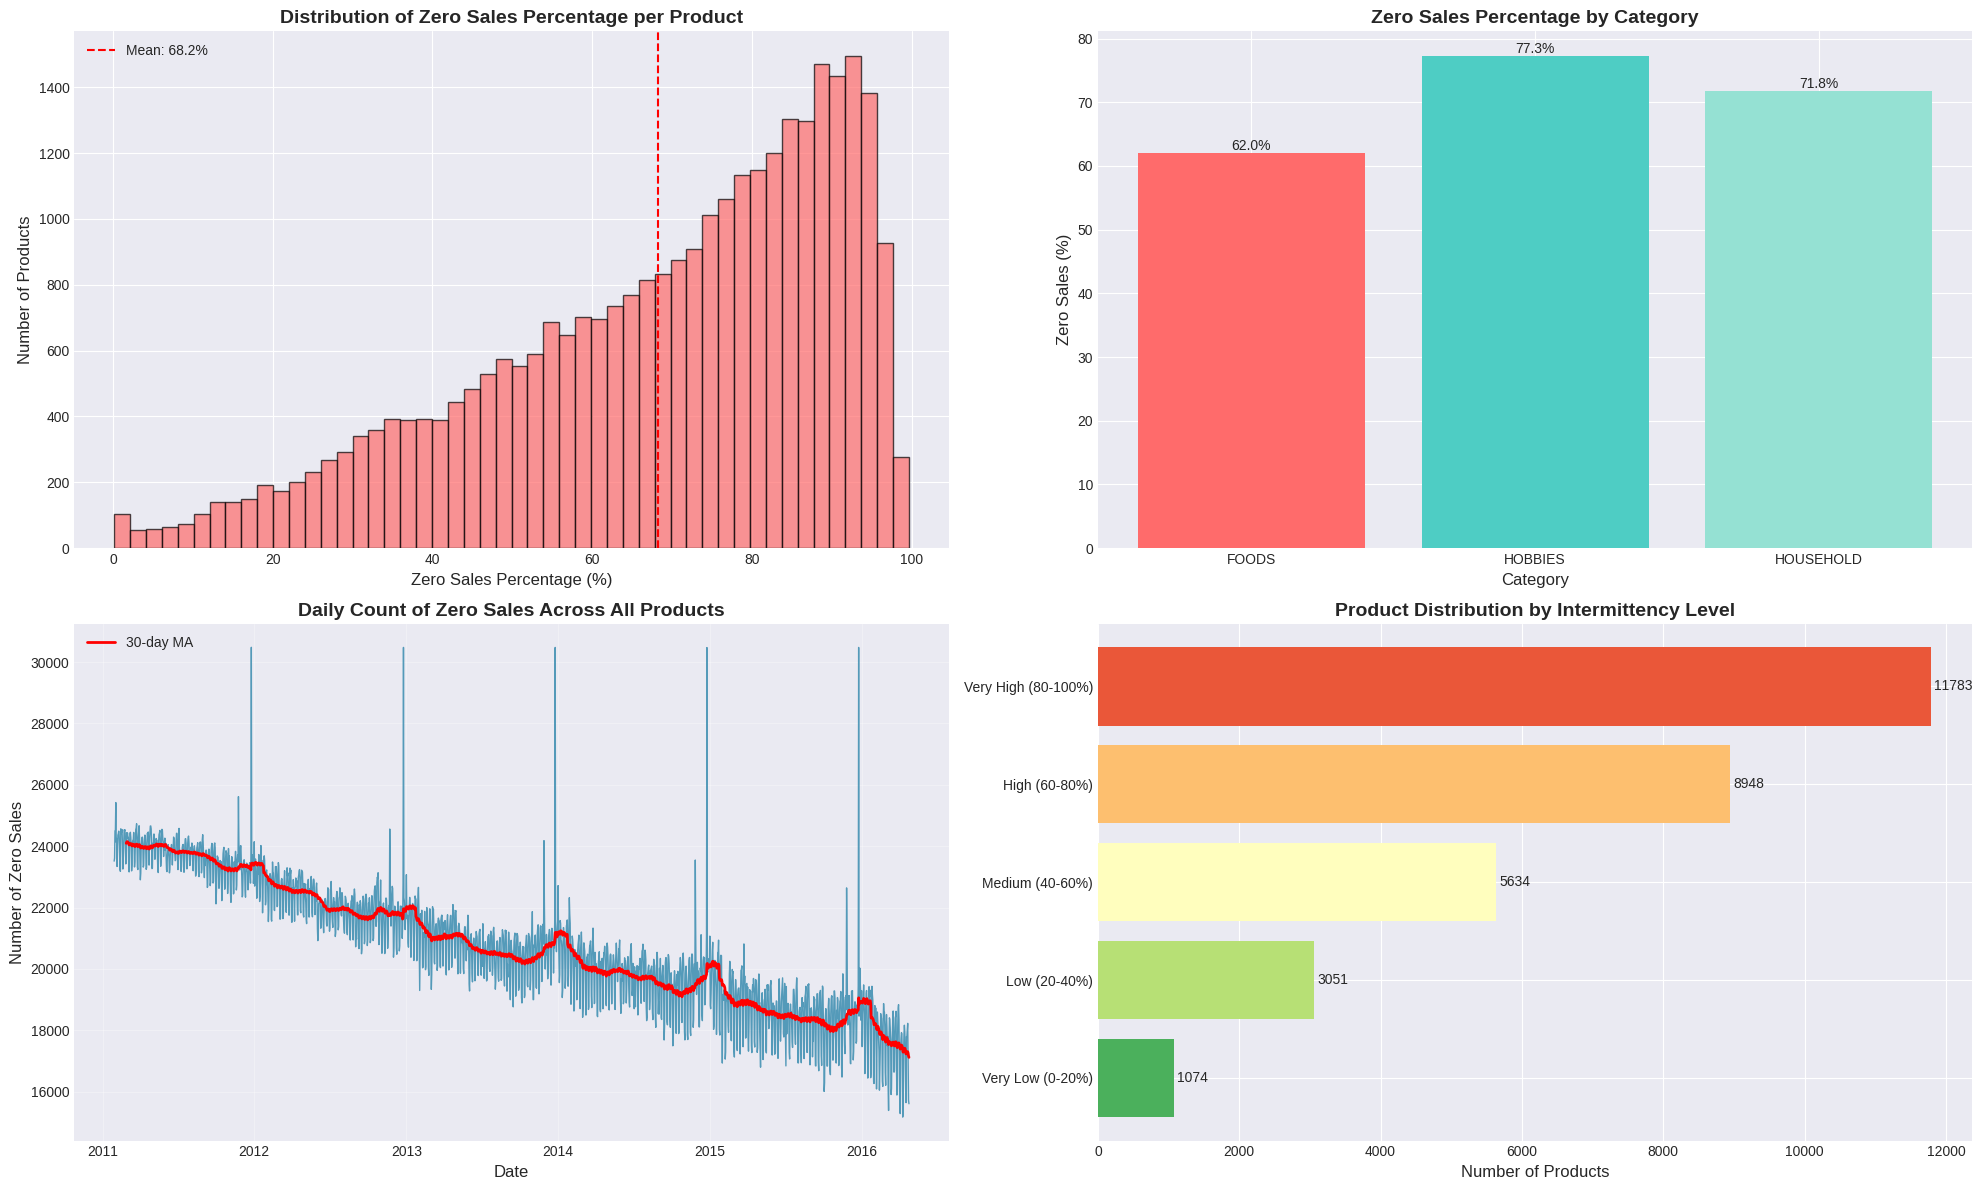

In [19]:
print("\n[9/12] Analyzing Zero Sales and Intermittency...")

# Calculate zero sales statistics
zero_counts = (sales[day_cols] == 0).sum(axis=1)
zero_percentage = (zero_counts / len(day_cols)) * 100

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Distribution of zero sales percentage
axes[0, 0].hist(zero_percentage, bins=50, color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Zero Sales Percentage per Product', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Zero Sales Percentage (%)', fontsize=12)
axes[0, 0].set_ylabel('Number of Products', fontsize=12)
axes[0, 0].axvline(zero_percentage.mean(), color='red', linestyle='--', 
                   label=f'Mean: {zero_percentage.mean():.1f}%')
axes[0, 0].legend()

# Zero sales by category
zero_by_cat = sales.groupby('cat_id').apply(
    lambda x: ((x[day_cols] == 0).sum().sum() / (len(x) * len(day_cols))) * 100
)
axes[0, 1].bar(zero_by_cat.index, zero_by_cat.values, 
               color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
axes[0, 1].set_title('Zero Sales Percentage by Category', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Category', fontsize=12)
axes[0, 1].set_ylabel('Zero Sales (%)', fontsize=12)
for i, v in enumerate(zero_by_cat.values):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Daily zero sales count over time
daily_zeros = (sales[day_cols] == 0).sum(axis=0).values
axes[1, 0].plot(dates, daily_zeros, linewidth=1, color='#2E86AB', alpha=0.8)
ma_zeros = pd.Series(daily_zeros).rolling(window=30).mean()
axes[1, 0].plot(dates, ma_zeros, linewidth=2, color='red', label='30-day MA')
axes[1, 0].set_title('Daily Count of Zero Sales Across All Products', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Number of Zero Sales', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Products by intermittency level
intermittency_levels = pd.cut(zero_percentage, bins=[0, 20, 40, 60, 80, 100],
                               labels=['Very Low (0-20%)', 'Low (20-40%)', 
                                       'Medium (40-60%)', 'High (60-80%)', 'Very High (80-100%)'])
intermittency_counts = intermittency_levels.value_counts().sort_index()
axes[1, 1].barh(range(len(intermittency_counts)), intermittency_counts.values,
                color=sns.color_palette("RdYlGn_r", len(intermittency_counts)))
axes[1, 1].set_title('Product Distribution by Intermittency Level', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Number of Products', fontsize=12)
axes[1, 1].set_yticks(range(len(intermittency_counts)))
axes[1, 1].set_yticklabels(intermittency_counts.index)
for i, v in enumerate(intermittency_counts.values):
    axes[1, 1].text(v + 50, i, str(v), va='center')

plt.tight_layout()
plt.savefig('08_zero_sales_intermittency.png', dpi=300, bbox_inches='tight')
plt.show()


[10/12] Analyzing Sales Distribution...


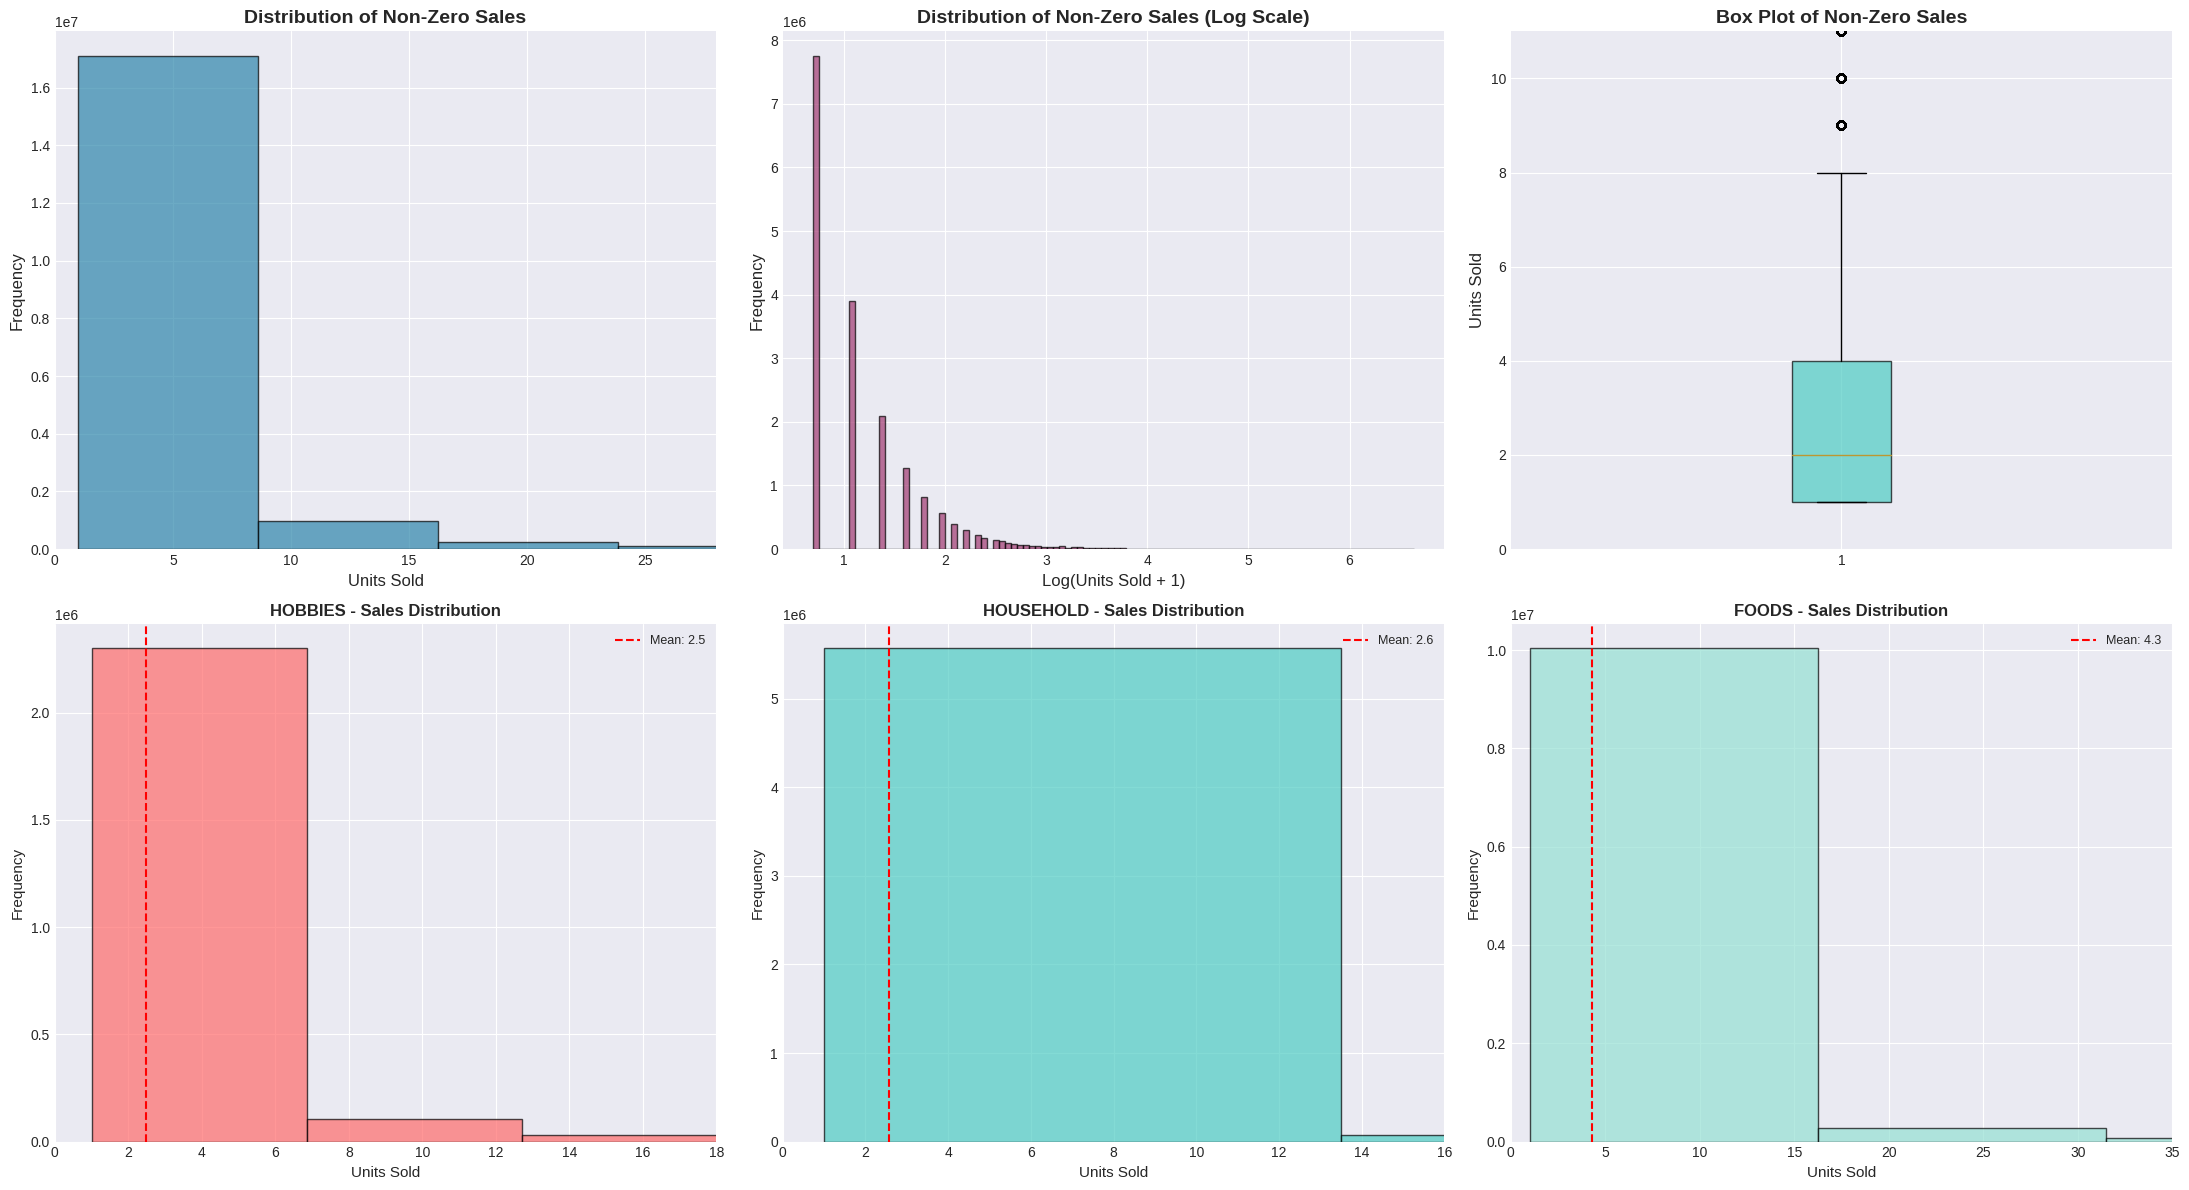

In [20]:
print("\n[10/12] Analyzing Sales Distribution...")

# Calculate statistics for non-zero sales
all_sales = sales[day_cols].values.flatten()
non_zero_sales = all_sales[all_sales > 0]

fig, axes = plt.subplots(2, 3, figsize=(22, 12))

# Overall sales distribution
axes[0, 0].hist(non_zero_sales, bins=100, color='#2E86AB', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Non-Zero Sales', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Units Sold', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_xlim(0, np.percentile(non_zero_sales, 99))

# Log scale distribution
axes[0, 1].hist(np.log1p(non_zero_sales), bins=100, color='#A23B72', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Non-Zero Sales (Log Scale)', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Log(Units Sold + 1)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

# Box plot of sales distribution
axes[0, 2].boxplot(non_zero_sales, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='#4ECDC4', alpha=0.7))
axes[0, 2].set_title('Box Plot of Non-Zero Sales', fontsize=14, weight='bold')
axes[0, 2].set_ylabel('Units Sold', fontsize=12)
axes[0, 2].set_ylim(0, np.percentile(non_zero_sales, 95))

# Sales distribution by category
for i, cat in enumerate(categories):
    cat_sales = sales[sales['cat_id'] == cat][day_cols].values.flatten()
    cat_sales_nz = cat_sales[cat_sales > 0]
    axes[1, i].hist(cat_sales_nz, bins=50, color=colors_cat[cat], alpha=0.7, edgecolor='black')
    axes[1, i].set_title(f'{cat} - Sales Distribution', fontsize=12, weight='bold')
    axes[1, i].set_xlabel('Units Sold', fontsize=11)
    axes[1, i].set_ylabel('Frequency', fontsize=11)
    axes[1, i].set_xlim(0, np.percentile(cat_sales_nz, 99))
    axes[1, i].axvline(cat_sales_nz.mean(), color='red', linestyle='--', 
                       label=f'Mean: {cat_sales_nz.mean():.1f}')
    axes[1, i].legend(fontsize=9)

plt.tight_layout()
plt.savefig('09_sales_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


[11/12] Analyzing Price Data...


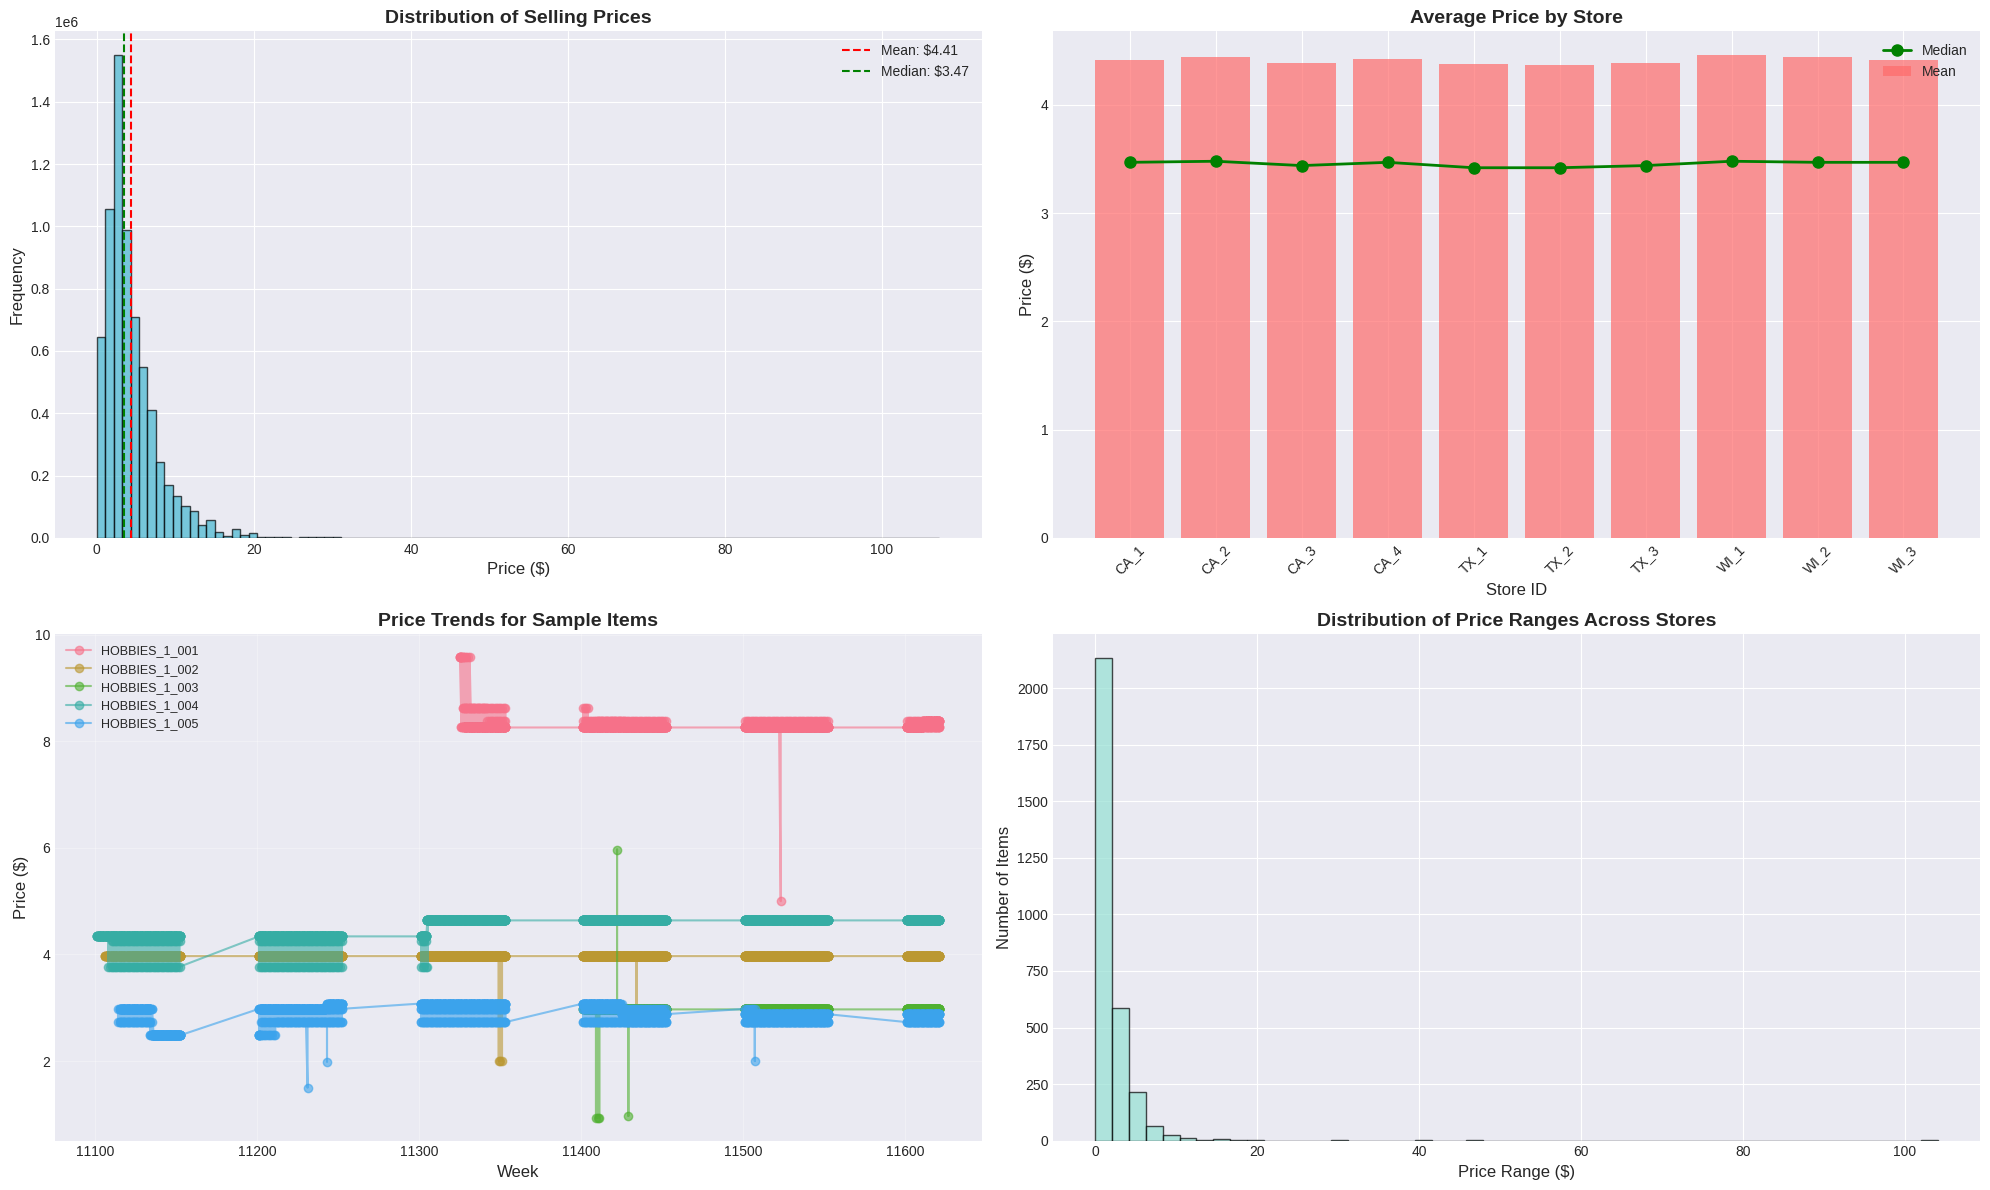

In [21]:
print("\n[11/12] Analyzing Price Data...")

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Price distribution
axes[0, 0].hist(prices['sell_price'], bins=100, color='#45B7D1', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Selling Prices', fontsize=14, weight='bold')
axes[0, 0].set_xlabel('Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(prices['sell_price'].mean(), color='red', linestyle='--', 
                   label=f"Mean: ${prices['sell_price'].mean():.2f}")
axes[0, 0].axvline(prices['sell_price'].median(), color='green', linestyle='--', 
                   label=f"Median: ${prices['sell_price'].median():.2f}")
axes[0, 0].legend()

# Price statistics by store
price_by_store = prices.groupby('store_id')['sell_price'].agg(['mean', 'median', 'std'])
x = range(len(price_by_store))
axes[0, 1].bar(x, price_by_store['mean'], alpha=0.7, label='Mean', color='#FF6B6B')
axes[0, 1].plot(x, price_by_store['median'], 'go-', label='Median', linewidth=2, markersize=8)
axes[0, 1].set_title('Average Price by Store', fontsize=14, weight='bold')
axes[0, 1].set_xlabel('Store ID', fontsize=12)
axes[0, 1].set_ylabel('Price ($)', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(price_by_store.index, rotation=45)
axes[0, 1].legend()

# Price trends over time (sample items)
sample_items = prices['item_id'].unique()[:5]
for item in sample_items:
    item_prices = prices[prices['item_id'] == item].sort_values('wm_yr_wk')
    axes[1, 0].plot(item_prices['wm_yr_wk'], item_prices['sell_price'], 
                    marker='o', alpha=0.6, label=item)

axes[1, 0].set_title('Price Trends for Sample Items', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Week', fontsize=12)
axes[1, 0].set_ylabel('Price ($)', fontsize=12)
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

# Price range by number of stores
price_range = prices.groupby('item_id')['sell_price'].agg(['min', 'max'])
price_range['range'] = price_range['max'] - price_range['min']
axes[1, 1].hist(price_range['range'], bins=50, color='#95E1D3', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Price Ranges Across Stores', fontsize=14, weight='bold')
axes[1, 1].set_xlabel('Price Range ($)', fontsize=12)
axes[1, 1].set_ylabel('Number of Items', fontsize=12)

plt.tight_layout()
plt.savefig('10_price_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


[12/12] Analyzing Calendar Events Impact...


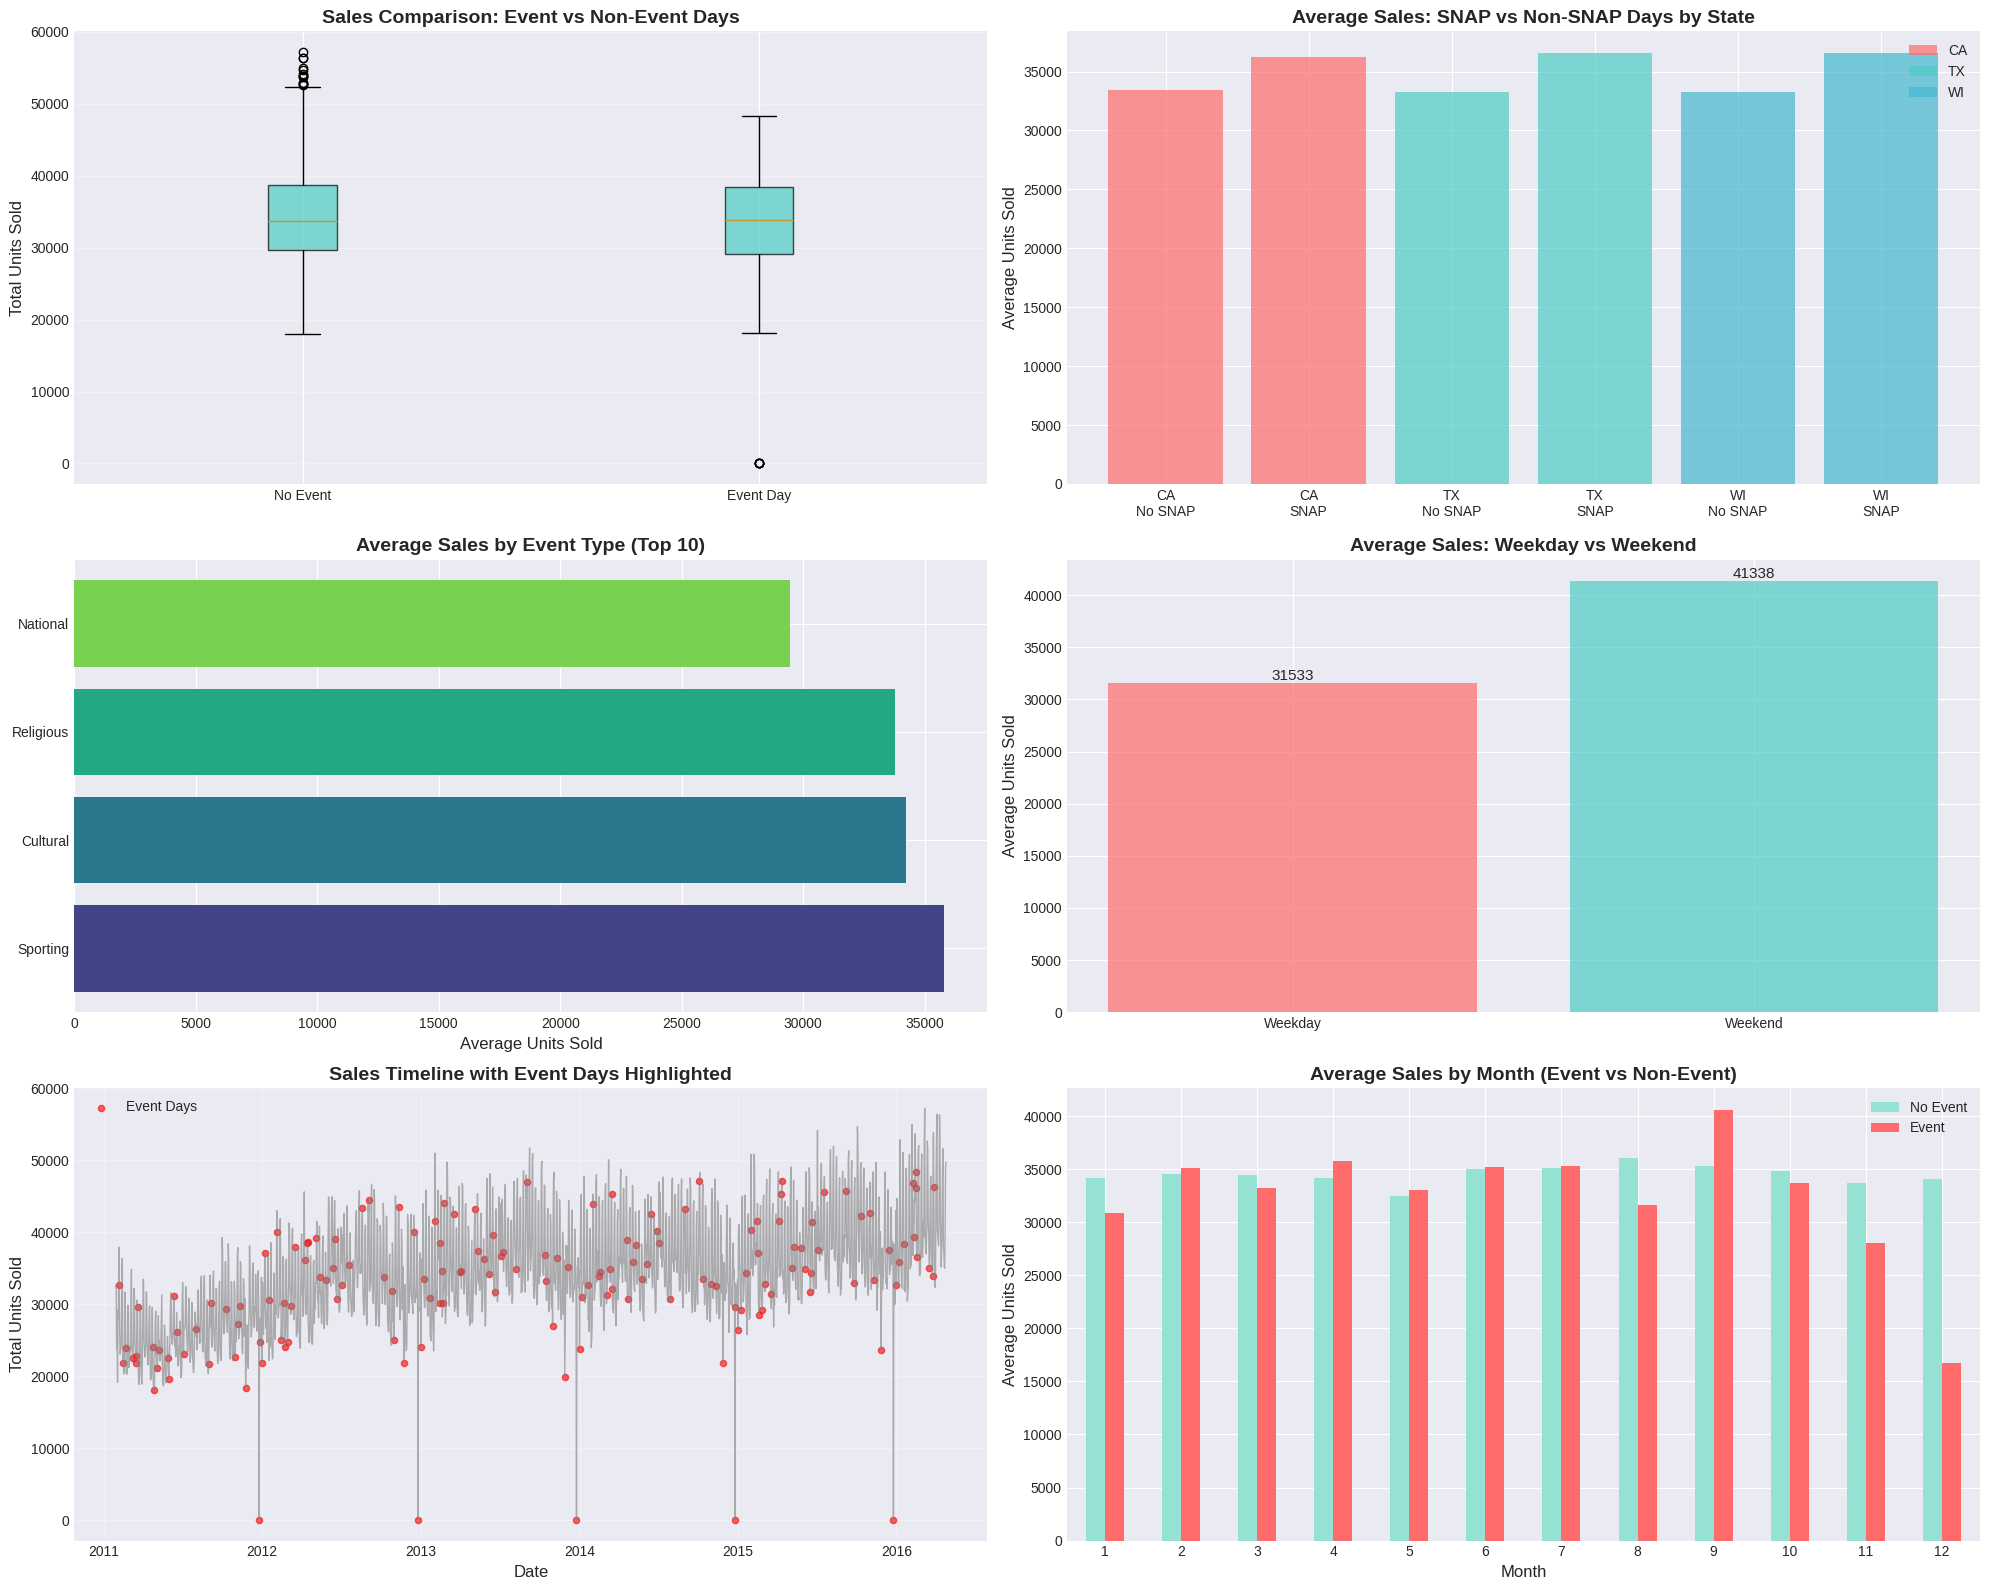

In [22]:
print("\n[12/12] Analyzing Calendar Events Impact...")

# Merge calendar with sales data
calendar_subset = calendar[calendar['d'].isin(day_cols)].copy()
calendar_subset['total_sales'] = daily_sales

fig, axes = plt.subplots(3, 2, figsize=(20, 16))

# Sales on event days vs non-event days
event_sales = calendar_subset[calendar_subset['event_name_1'].notna()]['total_sales']
non_event_sales = calendar_subset[calendar_subset['event_name_1'].isna()]['total_sales']

axes[0, 0].boxplot([non_event_sales, event_sales], labels=['No Event', 'Event Day'],
                    patch_artist=True, 
                    boxprops=dict(facecolor='#4ECDC4', alpha=0.7))
axes[0, 0].set_title('Sales Comparison: Event vs Non-Event Days', fontsize=14, weight='bold')
axes[0, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# SNAP days impact
snap_cols = ['snap_CA', 'snap_TX', 'snap_WI']
for snap_col in snap_cols:
    snap_sales = calendar_subset.groupby(snap_col)['total_sales'].mean()
    state = snap_col.split('_')[1]
    axes[0, 1].bar([f'{state}\nNo SNAP', f'{state}\nSNAP'], snap_sales.values, 
                   alpha=0.7, label=state, color=colors_state[state])

axes[0, 1].set_title('Average Sales: SNAP vs Non-SNAP Days by State', fontsize=14, weight='bold')
axes[0, 1].set_ylabel('Average Units Sold', fontsize=12)
axes[0, 1].legend()

# Sales by event type (top 10 events)
event_type_sales = calendar_subset[calendar_subset['event_type_1'].notna()].groupby(
    'event_type_1')['total_sales'].mean().sort_values(ascending=False).head(10)
axes[1, 0].barh(range(len(event_type_sales)), event_type_sales.values, 
                color=sns.color_palette("viridis", len(event_type_sales)))
axes[1, 0].set_title('Average Sales by Event Type (Top 10)', fontsize=14, weight='bold')
axes[1, 0].set_xlabel('Average Units Sold', fontsize=12)
axes[1, 0].set_yticks(range(len(event_type_sales)))
axes[1, 0].set_yticklabels(event_type_sales.index)

# Weekday vs Weekend sales
calendar_subset['is_weekend'] = calendar_subset['weekday'].isin(['Saturday', 'Sunday'])
weekend_comparison = calendar_subset.groupby('is_weekend')['total_sales'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_comparison.values, 
               color=['#FF6B6B', '#4ECDC4'], alpha=0.7)
axes[1, 1].set_title('Average Sales: Weekday vs Weekend', fontsize=14, weight='bold')
axes[1, 1].set_ylabel('Average Units Sold', fontsize=12)
for i, v in enumerate(weekend_comparison.values):
    axes[1, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=11)

# Sales trend with event markers
axes[2, 0].plot(dates, daily_sales, linewidth=1, alpha=0.6, color='gray')
event_dates = calendar_subset[calendar_subset['event_name_1'].notna()]['date']
event_sales_values = calendar_subset[calendar_subset['event_name_1'].notna()]['total_sales']
axes[2, 0].scatter(pd.to_datetime(event_dates), event_sales_values, 
                   color='red', s=20, alpha=0.6, label='Event Days')
axes[2, 0].set_title('Sales Timeline with Event Days Highlighted', fontsize=14, weight='bold')
axes[2, 0].set_xlabel('Date', fontsize=12)
axes[2, 0].set_ylabel('Total Units Sold', fontsize=12)
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Month comparison with events
calendar_subset['month'] = pd.to_datetime(calendar_subset['date']).dt.month
calendar_subset['has_event'] = calendar_subset['event_name_1'].notna().astype(int)
month_event_sales = calendar_subset.groupby(['month', 'has_event'])['total_sales'].mean().unstack()
month_event_sales.plot(kind='bar', ax=axes[2, 1], color=['#95E1D3', '#FF6B6B'])
axes[2, 1].set_title('Average Sales by Month (Event vs Non-Event)', fontsize=14, weight='bold')
axes[2, 1].set_xlabel('Month', fontsize=12)
axes[2, 1].set_ylabel('Average Units Sold', fontsize=12)
axes[2, 1].legend(['No Event', 'Event'], title='')
axes[2, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('11_calendar_events_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
print(f"\n📊 Overall Sales Statistics:")
print(f"   Total Sales (all products, all days): {all_sales.sum():,.0f} units")
print(f"   Average Daily Sales: {daily_sales.mean():,.0f} units")
print(f"   Median Daily Sales: {np.median(daily_sales):,.0f} units")
print(f"   Std Dev Daily Sales: {np.std(daily_sales):,.0f} units")

print(f"\n📦 Product Statistics:")
print(f"   Total Products: {sales.shape[0]:,}")
print(f"   Average Sales per Product: {all_sales.sum() / sales.shape[0]:,.0f} units")
print(f"   Products with >50% Zero Sales: {(zero_percentage > 50).sum():,}")

print(f"\n💰 Price Statistics:")
print(f"   Average Price: ${prices['sell_price'].mean():.2f}")
print(f"   Median Price: ${prices['sell_price'].median():.2f}")
print(f"   Min Price: ${prices['sell_price'].min():.2f}")
print(f"   Max Price: ${prices['sell_price'].max():.2f}")

print(f"\n📅 Time Period:")
print(f"   Start Date: {dates.min().strftime('%Y-%m-%d')}")
print(f"   End Date: {dates.max().strftime('%Y-%m-%d')}")
print(f"   Total Days: {len(dates):,}")

print(f"\n🎯 Best Performing:")
best_state = state_total_sales.idxmax()
best_store = store_sales_total.idxmax()
best_category = cat_total_sales.idxmax()
print(f"   State: {best_state} ({state_total_sales[best_state]:,.0f} units)")
print(f"   Store: {best_store} ({store_sales_total[best_store]:,.0f} units)")
print(f"   Category: {best_category} ({cat_total_sales[best_category]:,.0f} units)")


📊 Overall Sales Statistics:
   Total Sales (all products, all days): 65,695,409 units
   Average Daily Sales: 34,342 units
   Median Daily Sales: 33,732 units
   Std Dev Daily Sales: 7,344 units

📦 Product Statistics:
   Total Products: 30,490
   Average Sales per Product: 2,155 units
   Products with >50% Zero Sales: 23,916

💰 Price Statistics:
   Average Price: $4.41
   Median Price: $3.47
   Min Price: $0.01
   Max Price: $107.32

📅 Time Period:
   Start Date: 2011-01-29
   End Date: 2016-04-24
   Total Days: 1,913

🎯 Best Performing:
   State: CA (28,675,547 units)
   Store: CA_3 (11,188,180 units)
   Category: FOODS (45,089,939 units)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Evaluation Metrics - WRMSSE (M5 Competition), Weighted MAE, and R²

def mean_squared_error(y_true, y_pred):
    """Mean Squared Error (MSE)"""
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    """Mean Absolute Error (MAE)"""
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    """Root Mean Squared Error (RMSE)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def wrmsse(y_true, y_pred, weights=None):
    """Weighted Root Mean Squared Scaled Error (M5 Competition Metric)
    
    WRMSSE scales the squared errors by the variance of training data (using first differences)
    and weights by sales volume/importance.
    
    Formula: sqrt( sum(w_i * (y_true_i - y_pred_i)^2) / sum(w_i * scale_i) )
    Where scale_i = mean of squared first differences of the series
    """
    if weights is None:
        # Default: weight by actual values (normalized)
        weights = np.abs(y_true) / (np.sum(np.abs(y_true)) + 1e-10)
    else:
        weights = weights / (np.sum(weights) + 1e-10)
    
    # Calculate scale based on variance of first differences (as in M5)
    # For a single series, scale = mean of squared first differences
    if len(y_true) > 1:
        scale = np.mean(np.diff(y_true) ** 2)
    else:
        scale = 1.0
    scale = max(scale, 1e-10)  # Avoid division by zero
    
    # Calculate WRMSSE
    squared_errors = (y_true - y_pred) ** 2
    weighted_sse = np.sum(weights * squared_errors)
    wrmsse_val = np.sqrt(weighted_sse / scale)
    
    return wrmsse_val

def weighted_mae(y_true, y_pred, weights=None):
    """Weighted Mean Absolute Error
    Weights predictions by sales volume - larger values have more weight
    """
    if weights is None:
        # Default: weight by actual values (normalized)
        weights = np.abs(y_true) / (np.sum(np.abs(y_true)) + 1e-10)
    else:
        weights = weights / (np.sum(weights) + 1e-10)
    
    absolute_errors = np.abs(y_true - y_pred)
    weighted_mae_val = np.sum(weights * absolute_errors)
    return weighted_mae_val

def r_squared(y_true, y_pred):
    """R-squared (Coefficient of Determination)
    Measures the proportion of variance explained by the model
    R² = 1 - (SS_res / SS_tot)
    """
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - (ss_res / ss_tot)

def evaluate_predictions(y_true, y_pred, model_name):
    """Calculate all metrics: WRMSSE, Weighted MAE, R²"""
    results = {
        'Model': model_name,
        'WRMSSE': wrmsse(y_true, y_pred),
        'Weighted_MAE': weighted_mae(y_true, y_pred),
        'R_squared': r_squared(y_true, y_pred)
    }
    return results


In [34]:
# Load datasets
sales = pd.read_csv('/kaggle/input/forecasting-data/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/forecasting-data/calendar.csv')
prices = pd.read_csv('/kaggle/input/forecasting-data/sell_prices.csv')

# Extract day columns
day_cols = [col for col in sales.columns if col.startswith('d_')]
print(f"Total days in training: {len(day_cols)}")

# Define validation split (last 28 days for validation)
FORECAST_HORIZON = 28
train_days = day_cols[:-FORECAST_HORIZON]
valid_days = day_cols[-FORECAST_HORIZON:]

print(f"Training days: {len(train_days)}")
print(f"Validation days: {len(valid_days)}")

Total days in training: 1913
Training days: 1885
Validation days: 28


### Baselines

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def naive_forecast(train_data, horizon):
    """Simply repeat the last observed value"""
    last_value = train_data[-1]
    return np.full(horizon, last_value)

# Apply to aggregate sales
train_sales = sales[train_days].sum(axis=0).values
valid_sales = sales[valid_days].sum(axis=0).values

naive_pred = naive_forecast(train_sales, FORECAST_HORIZON)
naive_results = evaluate_predictions(valid_sales, naive_pred, 'Naive')

print(f"✓ Naive Forecast - WRMSSE: {naive_results['WRMSSE']:.4f}, Weighted MAE: {naive_results['Weighted_MAE']:.2f}, R²: {naive_results['R_squared']:.4f}")

✓ Naive Forecast - RMSE: 8184.11, WRMSSE: 1.2359


In [ ]:
def seasonal_naive_forecast(train_data, horizon, seasonality=7):
    """Repeat values from the same day of week"""
    predictions = []
    for i in range(horizon):
        # Get value from same day in previous week
        idx = len(train_data) - seasonality + (i % seasonality)
        if idx >= 0 and idx < len(train_data):
            predictions.append(train_data[idx])
        else:
            predictions.append(train_data[-1])
    return np.array(predictions)

seasonal_naive_pred = seasonal_naive_forecast(train_sales, FORECAST_HORIZON, seasonality=7)
seasonal_naive_results = evaluate_predictions(valid_sales, seasonal_naive_pred, 'Seasonal Naive (7d)')

print(f"✓ Seasonal Naive - WRMSSE: {seasonal_naive_results['WRMSSE']:.4f}, Weighted MAE: {seasonal_naive_results['Weighted_MAE']:.2f}, R²: {seasonal_naive_results['R_squared']:.4f}")

✓ Seasonal Naive - RMSE: 3947.48, WRMSSE: 0.5961


In [ ]:
def moving_average_forecast(train_data, horizon, window):
    """
    Sliding window moving average - recursively updates window with predictions
    Each new prediction becomes part of the window for the next prediction
    """
    predictions = []
    # Start with training data
    data_window = list(train_data)
    
    for _ in range(horizon):
        # Calculate MA from last 'window' values
        ma_value = np.mean(data_window[-window:])
        predictions.append(ma_value)
        # Add prediction to window for next iteration
        data_window.append(ma_value)
    
    return np.array(predictions)

results_list = []
results_list.append(naive_results)
results_list.append(seasonal_naive_results)

# Try different window sizes
for window in [7, 14, 28]:
    ma_pred = moving_average_forecast(train_sales, FORECAST_HORIZON, window)
    ma_results = evaluate_predictions(valid_sales, ma_pred, f'MA-{window}')
    results_list.append(ma_results)
    print(f"✓ MA-{window} (Sliding) - WRMSSE: {ma_results['WRMSSE']:.4f}, Weighted MAE: {ma_results['Weighted_MAE']:.2f}, R²: {ma_results['R_squared']:.4f}")

✓ MA-7 (Sliding) - RMSE: 6934.81, WRMSSE: 1.0472
✓ MA-14 (Sliding) - RMSE: 6922.04, WRMSSE: 1.0453
✓ MA-28 (Sliding) - RMSE: 7017.52, WRMSSE: 1.0597


In [ ]:
def weighted_moving_average_forecast(train_data, horizon, window):
    """
    Sliding window weighted moving average
    More recent values get higher weights, window slides with each prediction
    """
    predictions = []
    data_window = list(train_data)
    
    # Create weights (linear: more recent = higher weight)
    weights = np.arange(1, window + 1)
    weights = weights / weights.sum()
    
    for _ in range(horizon):
        # Calculate WMA from last 'window' values
        wma_value = np.dot(data_window[-window:], weights)
        predictions.append(wma_value)
        # Add prediction to window for next iteration
        data_window.append(wma_value)
    
    return np.array(predictions)

wma_pred = weighted_moving_average_forecast(train_sales, FORECAST_HORIZON, 28)
wma_results = evaluate_predictions(valid_sales, wma_pred, 'WMA-28')
results_list.append(wma_results)

print(f"✓ WMA-28 (Sliding) - WRMSSE: {wma_results['WRMSSE']:.4f}, Weighted MAE: {wma_results['Weighted_MAE']:.2f}, R²: {wma_results['R_squared']:.4f}")

✓ WMA-28 (Sliding) - RMSE: 7112.47, WRMSSE: 1.0741


In [ ]:
def exponential_smoothing_forecast(train_data, horizon, alpha=0.3):
    """
    Recursive exponential smoothing
    Each prediction is smoothed and used for the next prediction
    """
    # Calculate initial smoothed values on training data
    smoothed = [train_data[0]]
    for i in range(1, len(train_data)):
        smoothed.append(alpha * train_data[i] + (1 - alpha) * smoothed[-1])
    
    # Recursive forecasting
    predictions = []
    last_smoothed = smoothed[-1]
    
    for _ in range(horizon):
        # Forecast using last smoothed value
        forecast = last_smoothed
        predictions.append(forecast)
        # Update smoothed value with the forecast
        last_smoothed = alpha * forecast + (1 - alpha) * last_smoothed
    
    return np.array(predictions)

# Try different alpha values
for alpha in [0.1, 0.3, 0.5]:
    es_pred = exponential_smoothing_forecast(train_sales, FORECAST_HORIZON, alpha)
    es_results = evaluate_predictions(valid_sales, es_pred, f'ES-α{alpha}')
    results_list.append(es_results)
    print(f"✓ ES-α{alpha} (Recursive) - WRMSSE: {es_results['WRMSSE']:.4f}, Weighted MAE: {es_results['Weighted_MAE']:.2f}, R²: {es_results['R_squared']:.4f}")

✓ ES-α0.1 (Recursive) - RMSE: 7090.77, WRMSSE: 1.0708
✓ ES-α0.3 (Recursive) - RMSE: 7466.64, WRMSSE: 1.1275
✓ ES-α0.5 (Recursive) - RMSE: 8389.85, WRMSSE: 1.2670


In [ ]:
def create_lag_features(data, lags=[7, 14, 28]):
    """Create lagged features for regression"""
    X = []
    y = []
    
    max_lag = max(lags)
    for i in range(max_lag, len(data)):
        features = [data[i - lag] for lag in lags]
        features.append(i)  # Add time index
        X.append(features)
        y.append(data[i])
    
    return np.array(X), np.array(y)

# Prepare training data
lags = [1, 7, 14, 28]
X_train, y_train = create_lag_features(train_sales, lags)

# Train model
lr_model = Ridge(alpha=1.0)
lr_model.fit(X_train, y_train)

# Generate predictions iteratively
lr_predictions = []
recent_values = list(train_sales)

for _ in range(FORECAST_HORIZON):
    features = [recent_values[-lag] for lag in lags]
    features.append(len(recent_values))
    pred = lr_model.predict([features])[0]
    lr_predictions.append(max(0, pred))  # Ensure non-negative
    recent_values.append(pred)

lr_pred = np.array(lr_predictions)
lr_results = evaluate_predictions(valid_sales, lr_pred, 'Linear Regression')
results_list.append(lr_results)
print(f"✓ Linear Regression - WRMSSE: {lr_results['WRMSSE']:.4f}, Weighted MAE: {lr_results['Weighted_MAE']:.2f}, R²: {lr_results['R_squared']:.4f}")

✓ Linear Regression - RMSE: 2655.80, WRMSSE: 0.4011


In [ ]:
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('R_squared', ascending=False)  # Higher R² is better

print("\n" + results_df.to_string(index=False))
print("\n" + "="*80)

# Save results
results_df.to_csv('benchmark_results.csv', index=False)
print("✓ Results saved to 'benchmark_results.csv'")


              Model        RMSE         MAE      MAPE     SMAPE   WRMSSE
  Linear Regression 2655.803711 2241.345662  5.343209  5.313074 0.401053
  Linear Regression 2655.803711 2241.345662  5.343209  5.313074 0.401053
Seasonal Naive (7d) 3947.478074 3231.142857  7.354453  7.529919 0.596109
              MA-14 6922.041970 5764.857487 13.389529 13.439946 1.045298
               MA-7 6934.805421 6143.240519 14.808436 14.335704 1.047225
              MA-28 7017.519130 5902.434118 13.834373 13.767080 1.059716
            ES-α0.1 7090.765834 6036.456341 14.202428 14.084618 1.070777
             WMA-28 7112.471199 6015.856016 14.094841 14.035293 1.074054
            ES-α0.3 7466.639470 6774.386040 16.693630 15.770162 1.127537
              Naive 8184.106854 7457.071429 18.874782 17.249710 1.235882
            ES-α0.5 8389.851756 7627.539658 19.404430 17.609692 1.266952

✓ Results saved to 'benchmark_results.csv'


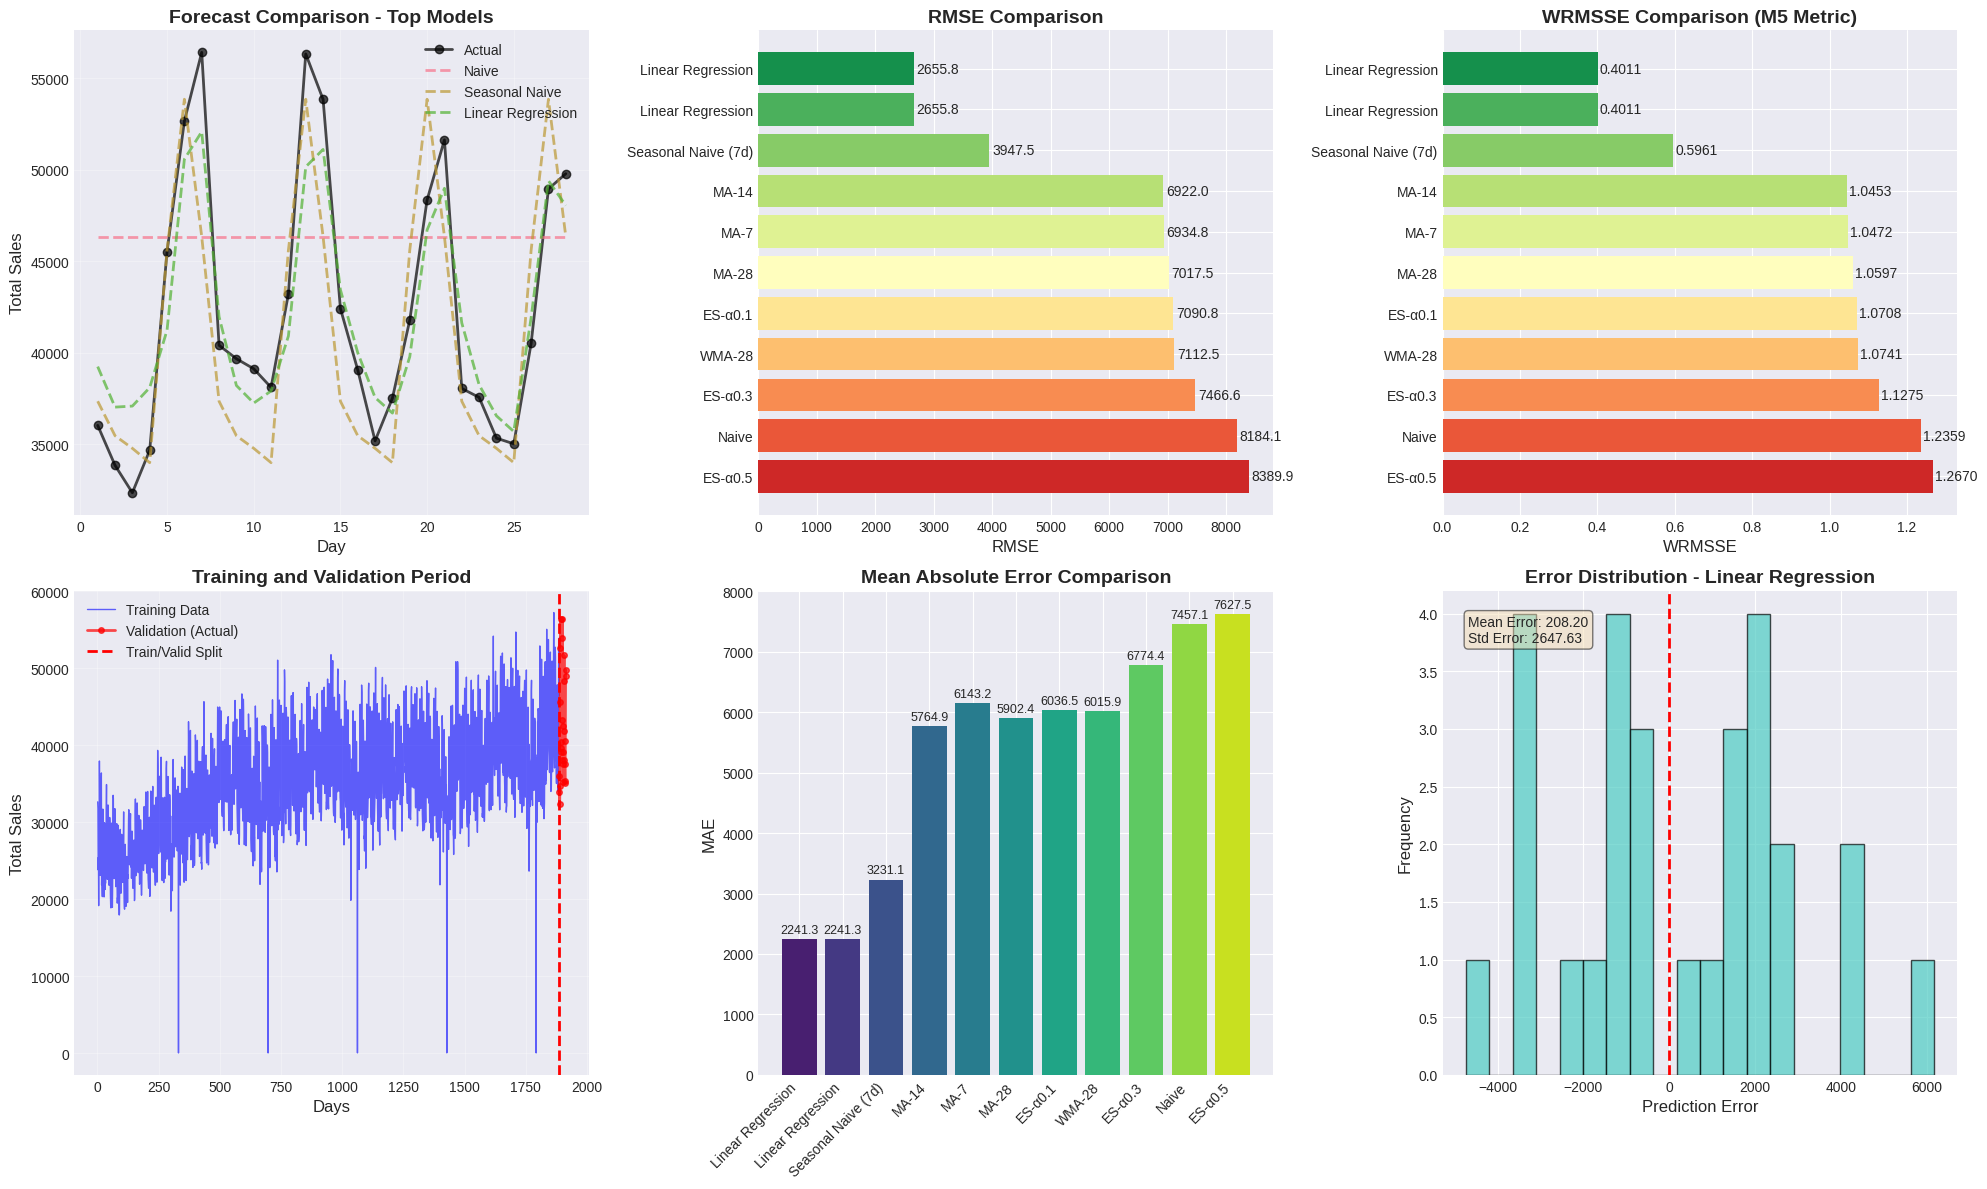

In [ ]:
fig = plt.figure(figsize=(20, 12))

# Plot 1: Actual vs Predictions for top 3 models
ax1 = plt.subplot(2, 3, 1)
days = np.arange(1, FORECAST_HORIZON + 1)
ax1.plot(days, valid_sales, 'ko-', linewidth=2, markersize=6, label='Actual', alpha=0.7)
ax1.plot(days, naive_pred, '--', linewidth=2, label='Naive', alpha=0.7)
ax1.plot(days, seasonal_naive_pred, '--', linewidth=2, label='Seasonal Naive', alpha=0.7)
ax1.plot(days, lr_pred, '--', linewidth=2, label='Linear Regression', alpha=0.7)
ax1.set_title('Forecast Comparison - Top Models', fontsize=14, weight='bold')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Total Sales', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: WRMSSE Comparison (M5 Competition Metric)
ax2 = plt.subplot(2, 3, 2)
wrmsse_values = results_df['WRMSSE'].values
model_names = results_df['Model'].values
colors = sns.color_palette("RdYlGn_r", len(wrmsse_values))
ax2.barh(range(len(wrmsse_values)), wrmsse_values, color=colors)
ax2.set_yticks(range(len(model_names)))
ax2.set_yticklabels(model_names)
ax2.set_xlabel('WRMSSE', fontsize=12)
ax2.set_title('WRMSSE Comparison (M5 Metric)', fontsize=14, weight='bold')
ax2.invert_yaxis()
for i, v in enumerate(wrmsse_values):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center')

# Plot 3: R² Comparison
ax3 = plt.subplot(2, 3, 3)
r2_values = results_df['R_squared'].values
colors = sns.color_palette("RdYlGn", len(r2_values))  # Green for higher R² is better
ax3.barh(range(len(r2_values)), r2_values, color=colors)
ax3.set_yticks(range(len(model_names)))
ax3.set_yticklabels(model_names)
ax3.set_xlabel('R²', fontsize=12)
ax3.set_title('R² Comparison (Higher is Better)', fontsize=14, weight='bold')
ax3.invert_yaxis()
for i, v in enumerate(r2_values):
    ax3.text(v + 0.01, i, f'{v:.4f}', va='center')

# Plot 4: Training Data with Validation Period
ax4 = plt.subplot(2, 3, 4)
all_days = np.arange(1, len(train_sales) + FORECAST_HORIZON + 1)
ax4.plot(all_days[:len(train_sales)], train_sales, 'b-', linewidth=1, label='Training Data', alpha=0.6)
ax4.plot(all_days[len(train_sales):], valid_sales, 'ro-', linewidth=2, markersize=4, label='Validation (Actual)', alpha=0.7)
ax4.axvline(x=len(train_sales), color='red', linestyle='--', linewidth=2, label='Train/Valid Split')
ax4.set_title('Training and Validation Period', fontsize=14, weight='bold')
ax4.set_xlabel('Days', fontsize=12)
ax4.set_ylabel('Total Sales', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Weighted MAE Comparison
ax5 = plt.subplot(2, 3, 5)
wmae_values = results_df['Weighted_MAE'].values
colors = sns.color_palette("viridis", len(wmae_values))
ax5.bar(range(len(wmae_values)), wmae_values, color=colors)
ax5.set_xticks(range(len(model_names)))
ax5.set_xticklabels(model_names, rotation=45, ha='right')
ax5.set_ylabel('Weighted MAE', fontsize=12)
ax5.set_title('Weighted MAE Comparison', fontsize=14, weight='bold')
for i, v in enumerate(wmae_values):
    ax5.text(i, v + 50, f'{v:.1f}', ha='center', va='bottom', fontsize=9)

# Plot 6: Error Distribution for Best Model
ax6 = plt.subplot(2, 3, 6)
best_model_idx = results_df['R_squared'].idxmax()  # Higher R² is better
best_model_name = results_df.loc[best_model_idx, 'Model']

# Get predictions for best model
if best_model_name == 'Naive':
    best_pred = naive_pred
elif best_model_name.startswith('Seasonal'):
    best_pred = seasonal_naive_pred
elif best_model_name == 'Linear Regression':
    best_pred = lr_pred
else:
    # For MA or ES models, use the first MA model as fallback
    best_pred = moving_average_forecast(train_sales, FORECAST_HORIZON, 7)

errors = valid_sales - best_pred
ax6.hist(errors, bins=20, color='#4ECDC4', alpha=0.7, edgecolor='black')
ax6.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax6.set_title(f'Error Distribution - {best_model_name}', fontsize=14, weight='bold')
ax6.set_xlabel('Prediction Error', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.text(0.05, 0.95, f'Mean Error: {errors.mean():.2f}\nStd Error: {errors.std():.2f}',
         transform=ax6.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('benchmark_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Better Model: LightGBM 

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

In [10]:
def reduce_mem_usage(df, verbose=True):
    """Reduce memory usage by optimizing dtypes"""
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        # Skip datetime and object types
        if col_type != object and col_type.name != 'category' and 'datetime' not in str(col_type):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'   Memory usage: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    
    return df

In [6]:
FORECAST_HORIZON = 28
VALIDATION_DAYS = 28
NUM_STORES_TO_TRAIN = 10  # Train all 10 stores sequentially

In [11]:
# Load sales with optimized dtypes
print("   Loading sales data...")
sales = pd.read_csv('/kaggle/input/forecasting-data/sales_train_validation.csv')
sales = reduce_mem_usage(sales)

# Load calendar
print("   Loading calendar data...")
calendar = pd.read_csv('/kaggle/input/forecasting-data/calendar.csv')
calendar = reduce_mem_usage(calendar)

# Load prices
print("   Loading prices data...")
prices = pd.read_csv('/kaggle/input/forecasting-data/sell_prices.csv')
prices = reduce_mem_usage(prices)

day_cols = [col for col in sales.columns if col.startswith('d_')]
print(f"✓ Loaded {len(day_cols)} days of data")

gc.collect()

   Loading sales data...
   Memory usage: 446.40 MB -> 95.00 MB (78.7% reduction)
   Loading calendar data...
   Memory usage: 0.21 MB -> 0.12 MB (41.9% reduction)
   Loading prices data...
   Memory usage: 208.77 MB -> 143.53 MB (31.2% reduction)
✓ Loaded 1913 days of data


34

In [12]:
print("\n[2/8] Preparing Calendar Features...")

calendar['date'] = pd.to_datetime(calendar['date'])
calendar['year'] = calendar['date'].dt.year.astype(np.int16)
calendar['month'] = calendar['date'].dt.month.astype(np.int8)
calendar['week'] = calendar['date'].dt.isocalendar().week.astype(np.int8)
calendar['day'] = calendar['date'].dt.day.astype(np.int8)
calendar['dayofweek'] = calendar['date'].dt.dayofweek.astype(np.int8)
calendar['is_weekend'] = calendar['dayofweek'].isin([5, 6]).astype(np.int8)

# Event features - use efficient encoding
calendar['has_event'] = calendar['event_name_1'].notna().astype(np.int8)
calendar['snap_any'] = calendar[['snap_CA', 'snap_TX', 'snap_WI']].max(axis=1).astype(np.int8)

# Keep only needed columns
calendar = calendar[['d', 'date', 'wm_yr_wk', 'year', 'month', 'week', 'day', 
                    'dayofweek', 'is_weekend', 'has_event', 'snap_CA', 'snap_TX', 
                    'snap_WI', 'snap_any']]

calendar = reduce_mem_usage(calendar)
print("✓ Calendar features prepared")

gc.collect()


[2/8] Preparing Calendar Features...
   Memory usage: 0.06 MB -> 0.06 MB (0.0% reduction)
✓ Calendar features prepared


56

In [13]:
print("\n[3/8] Preparing Price Features...")

# Aggregate prices to daily level
prices_daily = prices.merge(calendar[['wm_yr_wk', 'd']], on='wm_yr_wk', how='left')

# Calculate price features efficiently
print("   Calculating price momentum...")
prices_sorted = prices_daily.sort_values(['store_id', 'item_id', 'wm_yr_wk'])
prices_sorted['price_change'] = prices_sorted.groupby(['store_id', 'item_id'])['sell_price'].diff()
prices_sorted['price_change'] = prices_sorted['price_change'].fillna(0).astype(np.float32)

# Keep only needed columns
prices_daily = prices_sorted[['store_id', 'item_id', 'd', 'sell_price', 'price_change']]
prices_daily = reduce_mem_usage(prices_daily)

del prices, prices_sorted
gc.collect()


[3/8] Preparing Price Features...
   Calculating price momentum...
   Memory usage: 1820.96 MB -> 1820.96 MB (0.0% reduction)


0

In [14]:
def create_features_efficient(sales_df, store_id, start_idx, end_idx, calendar_df, prices_df):
    """
    Memory-efficient feature creation for one store at a time
    """
    print(f"\n   Processing {store_id}...")
    
    # Filter sales for this store only
    store_sales = sales_df[sales_df['store_id'] == store_id].copy()
    
    # Select day range
    selected_days = day_cols[start_idx:end_idx]
    
    # Melt to long format (memory intensive step)
    print(f"      Melting data...")
    data = store_sales.melt(
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        value_vars=selected_days,
        var_name='d',
        value_name='sales'
    )
    data['sales'] = data['sales'].astype(np.float32)
    
    del store_sales
    gc.collect()
    
    # Merge calendar (only needed columns)
    print(f"      Merging calendar...")
    data = data.merge(calendar_df, on='d', how='left')
    
    # Merge prices
    print(f"      Merging prices...")
    data = data.merge(prices_df, on=['store_id', 'item_id', 'd'], how='left')
    
    # Fill missing prices efficiently
    data['sell_price'].fillna(data.groupby('item_id')['sell_price'].transform('median'), inplace=True)
    data['price_change'].fillna(0, inplace=True)
    
    # Sort for lag features
    data = data.sort_values(['item_id', 'date'])
    
    # Create CRITICAL lag features only (most important)
    print(f"      Creating lag features...")
    lags = [7, 14, 28]
    for lag in lags:
        data[f'lag_{lag}'] = data.groupby('item_id')['sales'].shift(lag).astype(np.float32)
    
    # Create CRITICAL rolling features (keep minimal)
    print(f"      Creating rolling features...")
    data['roll_mean_7'] = data.groupby('item_id')['sales'].transform(
        lambda x: x.rolling(7, min_periods=1).mean().shift(1)
    ).astype(np.float32)
    
    data['roll_mean_28'] = data.groupby('item_id')['sales'].transform(
        lambda x: x.rolling(28, min_periods=1).mean().shift(1)
    ).astype(np.float32)
    
    # Price relative to mean
    data['price_rel'] = (data.groupby('item_id')['sell_price'].transform(
        lambda x: x / x.mean()
    )).astype(np.float32)
    
    # SNAP by state
    data['snap'] = 0
    if store_id.endswith('CA'):
        data['snap'] = data['snap_CA']
    elif store_id.endswith('TX'):
        data['snap'] = data['snap_TX']
    elif store_id.endswith('WI'):
        data['snap'] = data['snap_WI']
    data['snap'] = data['snap'].astype(np.int8)
    
    # Drop intermediate columns to save memory
    data = data.drop(['snap_CA', 'snap_TX', 'snap_WI', 'date', 'wm_yr_wk', 
                     'id', 'state_id'], axis=1)
    
    # Reduce memory
    data = reduce_mem_usage(data, verbose=False)
    
    print(f"      Final shape: {data.shape}")
    gc.collect()
    
    return data

In [15]:
cat_features = ['item_id', 'dept_id', 'cat_id']
num_features = ['sell_price', 'price_change', 'price_rel',
                'year', 'month', 'week', 'day', 'dayofweek',
                'is_weekend', 'has_event', 'snap', 'snap_any',
                'lag_7', 'lag_14', 'lag_28',
                'roll_mean_7', 'roll_mean_28']

all_features = cat_features + num_features

In [ ]:
print("\n[5/8] Training Store-Level Models...")

stores = sales['store_id'].unique()
models = {}
store_results = []

# LightGBM parameters (optimized for memory)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 8,
    'min_child_samples': 30,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'n_jobs': 4,  # Limit threads to save memory
    'max_bin': 255
}

# Training and validation split
val_start_idx = len(day_cols) - VALIDATION_DAYS

for store in stores:
    print(f"\n{'='*60}")
    print(f"Training {store}")
    print(f"{'='*60}")
    
    # Create training data for this store
    train_data = create_features_efficient(
        sales, store, 0, val_start_idx, calendar, prices_daily
    )
    
    # Create validation data for this store
    val_data = create_features_efficient(
        sales, store, 0, len(day_cols), calendar, prices_daily
    )
    val_data = val_data[val_data['d'].isin(day_cols[-VALIDATION_DAYS:])]
    
    # Drop NaN rows
    train_data = train_data.dropna(subset=all_features)
    val_data = val_data.dropna(subset=all_features)
    
    print(f"   Train samples: {train_data.shape[0]:,}")
    print(f"   Val samples: {val_data.shape[0]:,}")
    
    # Prepare features
    X_train = train_data[all_features].copy()
    y_train = train_data['sales'].values
    X_val = val_data[all_features].copy()
    y_val = val_data['sales'].values
    
    # Encode categoricals
    for col in cat_features:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
    
    # Create LightGBM datasets
    print(f"   Creating LightGBM datasets...")
    train_set = lgb.Dataset(X_train, y_train, categorical_feature=cat_features, free_raw_data=True)
    val_set = lgb.Dataset(X_val, y_val, categorical_feature=cat_features, reference=train_set, free_raw_data=True)
    
    # Clear training data from memory
    del train_data, X_train, y_train
    gc.collect()
    
    # Train
    print(f"   Training model...")
    model = lgb.train(
        params,
        train_set,
        num_boost_round=300,  # Reduced for memory
        valid_sets=[val_set],
        valid_names=['valid'],
        callbacks=[lgb.early_stopping(30), lgb.log_evaluation(50)]
    )
    
    models[store] = model
    
    # Evaluate
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = np.maximum(y_pred, 0)
    
    wrmsse_val = wrmsse(y_val, y_pred)
    w_mae = weighted_mae(y_val, y_pred)
    r2 = r_squared(y_val, y_pred)
    
    store_results.append({
        'Store': store,
        'WRMSSE': wrmsse_val,
        'Weighted_MAE': w_mae,
        'R_squared': r2,
        'Best_Iteration': model.best_iteration,
        'Train_Samples': len(y_val)
    })
    
    print(f"\n   ✓ {store} Results:")
    print(f"      WRMSSE: {wrmsse_val:.4f}")
    print(f"      Weighted MAE: {w_mae:.2f}")
    print(f"      R²: {r2:.4f}")
    print(f"      Best Iteration: {model.best_iteration}")
    
    # Save model to disk to free memory
    model.save_model(f'model_{store}.txt')
    
    # Clear everything
    del val_data, X_val, y_val, y_pred, train_set, val_set
    gc.collect()


[5/8] Training Store-Level Models...

Training CA_1

   Processing CA_1...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5747365, 23)

   Processing CA_1...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5832737, 23)
   Train samples: 5,661,993
   Val samples: 85,372
   Creating LightGBM datasets...
   Training model...
Training until validation scores don't improve for 30 rounds
[50]	valid's rmse: 2.05116
[100]	valid's rmse: 2.0317
[150]	valid's rmse: 2.02962
[200]	valid's rmse: 2.0285
[250]	valid's rmse: 2.0275
Early stopping, best iteration is:
[264]	valid's rmse: 2.02634

   ✓ CA_1 Results:
      RMSE: 2.03
      MAE: 1.04
      Best Iteration: 264

Training CA_2

   Processing CA_2...
      Melting data...
      Merging calendar...
      Merging prices...
     

In [20]:
all_predictions = []
all_actuals = []
daily_predictions = np.zeros(VALIDATION_DAYS)
daily_actuals = np.zeros(VALIDATION_DAYS)

for store in stores:
    print(f"   Loading predictions for {store}...")
    
    # Recreate validation data for this store
    val_data_store = create_features_efficient(
        sales, store, 0, len(day_cols), calendar, prices_daily
    )
    val_data_store = val_data_store[val_data_store['d'].isin(day_cols[-VALIDATION_DAYS:])]
    val_data_store = val_data_store.dropna(subset=all_features)
    
    # Prepare features
    X_val_store = val_data_store[all_features].copy()
    y_val_store = val_data_store['sales'].values
    
    # Encode categoricals
    for col in cat_features:
        X_val_store[col] = X_val_store[col].astype('category')
    
    # Load model and predict
    model = lgb.Booster(model_file=f'model_{store}.txt')
    y_pred_store = model.predict(X_val_store, num_iteration=model.best_iteration)
    y_pred_store = np.maximum(y_pred_store, 0)
    
    # Store all predictions
    all_predictions.extend(y_pred_store)
    all_actuals.extend(y_val_store)
    
    # Aggregate by day for this store
    val_data_store['pred'] = y_pred_store
    for day_idx, day in enumerate(day_cols[-VALIDATION_DAYS:]):
        day_mask = val_data_store['d'] == day
        daily_predictions[day_idx] += val_data_store.loc[day_mask, 'pred'].sum()
        daily_actuals[day_idx] += val_data_store.loc[day_mask, 'sales'].sum()
    
    del val_data_store, X_val_store, y_val_store, y_pred_store
    gc.collect()

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)

   Loading predictions for CA_1...

   Processing CA_1...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5832737, 23)
   Loading predictions for CA_2...

   Processing CA_2...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5832737, 23)
   Loading predictions for CA_3...

   Processing CA_3...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5832737, 23)
   Loading predictions for CA_4...

   Processing CA_4...
      Melting data...
      Merging calendar...
      Merging prices...
      Creating lag features...
      Creating rolling features...
      Final shape: (5832737, 23)
   Loading predictions for TX_1...

   Processing TX_1...
      Melting data...
    

In [ ]:
# Overall metrics (all products, all stores)
overall_wrmsse = wrmsse(all_actuals, all_predictions)
overall_w_mae = weighted_mae(all_actuals, all_predictions)
overall_r2 = r_squared(all_actuals, all_predictions)

# Daily aggregate metrics (total sales per day)
daily_wrmsse = wrmsse(daily_actuals, daily_predictions)
daily_w_mae = weighted_mae(daily_actuals, daily_predictions)
daily_r2 = r_squared(daily_actuals, daily_predictions)

print(f"\n{'='*80}")
print("AGGREGATE PERFORMANCE METRICS")
print(f"{'='*80}")

print(f"\n📊 ITEM-LEVEL METRICS (all products, all stores):")
print(f"   WRMSSE:       {overall_wrmsse:.4f}")
print(f"   Weighted MAE: {overall_w_mae:.2f}")
print(f"   R²:           {overall_r2:.4f}")

print(f"\n📊 DAILY AGGREGATE METRICS (total sales per day):")
print(f"   WRMSSE:       {daily_wrmsse:.4f}")
print(f"   Weighted MAE: {daily_w_mae:.2f}")
print(f"   R²:           {daily_r2:.4f}")
print(f"   Avg Daily Sales (Actual):    {daily_actuals.mean():,.0f} units")
print(f"   Avg Daily Sales (Predicted): {daily_predictions.mean():,.0f} units")

# Store-level summary
store_results_df = pd.DataFrame(store_results)
print(f"\n📊 PER-STORE STATISTICS:")
print(f"   Best Store R²:  {store_results_df['R_squared'].max():.4f} ({store_results_df.loc[store_results_df['R_squared'].idxmax(), 'Store']})")
print(f"   Worst Store R²: {store_results_df['R_squared'].min():.4f} ({store_results_df.loc[store_results_df['R_squared'].idxmin(), 'Store']})")
print(f"   Avg WRMSSE:      {store_results_df['WRMSSE'].mean():.4f}")
print(f"   Avg Weighted MAE: {store_results_df['Weighted_MAE'].mean():.2f}")


AGGREGATE PERFORMANCE METRICS

📊 ITEM-LEVEL METRICS (all products, all stores):
   RMSE:    1.92
   MAE:     0.97
   MAPE:    55.36%
   WRMSSE:  0.5337

📊 DAILY AGGREGATE METRICS (total sales per day):
   RMSE:    2112.52
   MAE:     1690.35
   Avg Daily Sales (Actual):    42,272 units
   Avg Daily Sales (Predicted): 42,222 units

📈 IMPROVEMENT OVER BASELINE:
   Baseline (MA-14) RMSE: 6922.00
   LightGBM Daily RMSE:   2112.52
   Improvement:           69.5%

📊 PER-STORE STATISTICS:
   Best Store RMSE:  1.34 (CA_4)
   Worst Store RMSE: 2.61 (WI_2)
   Avg Store RMSE:   1.88
   Std Store RMSE:   0.40


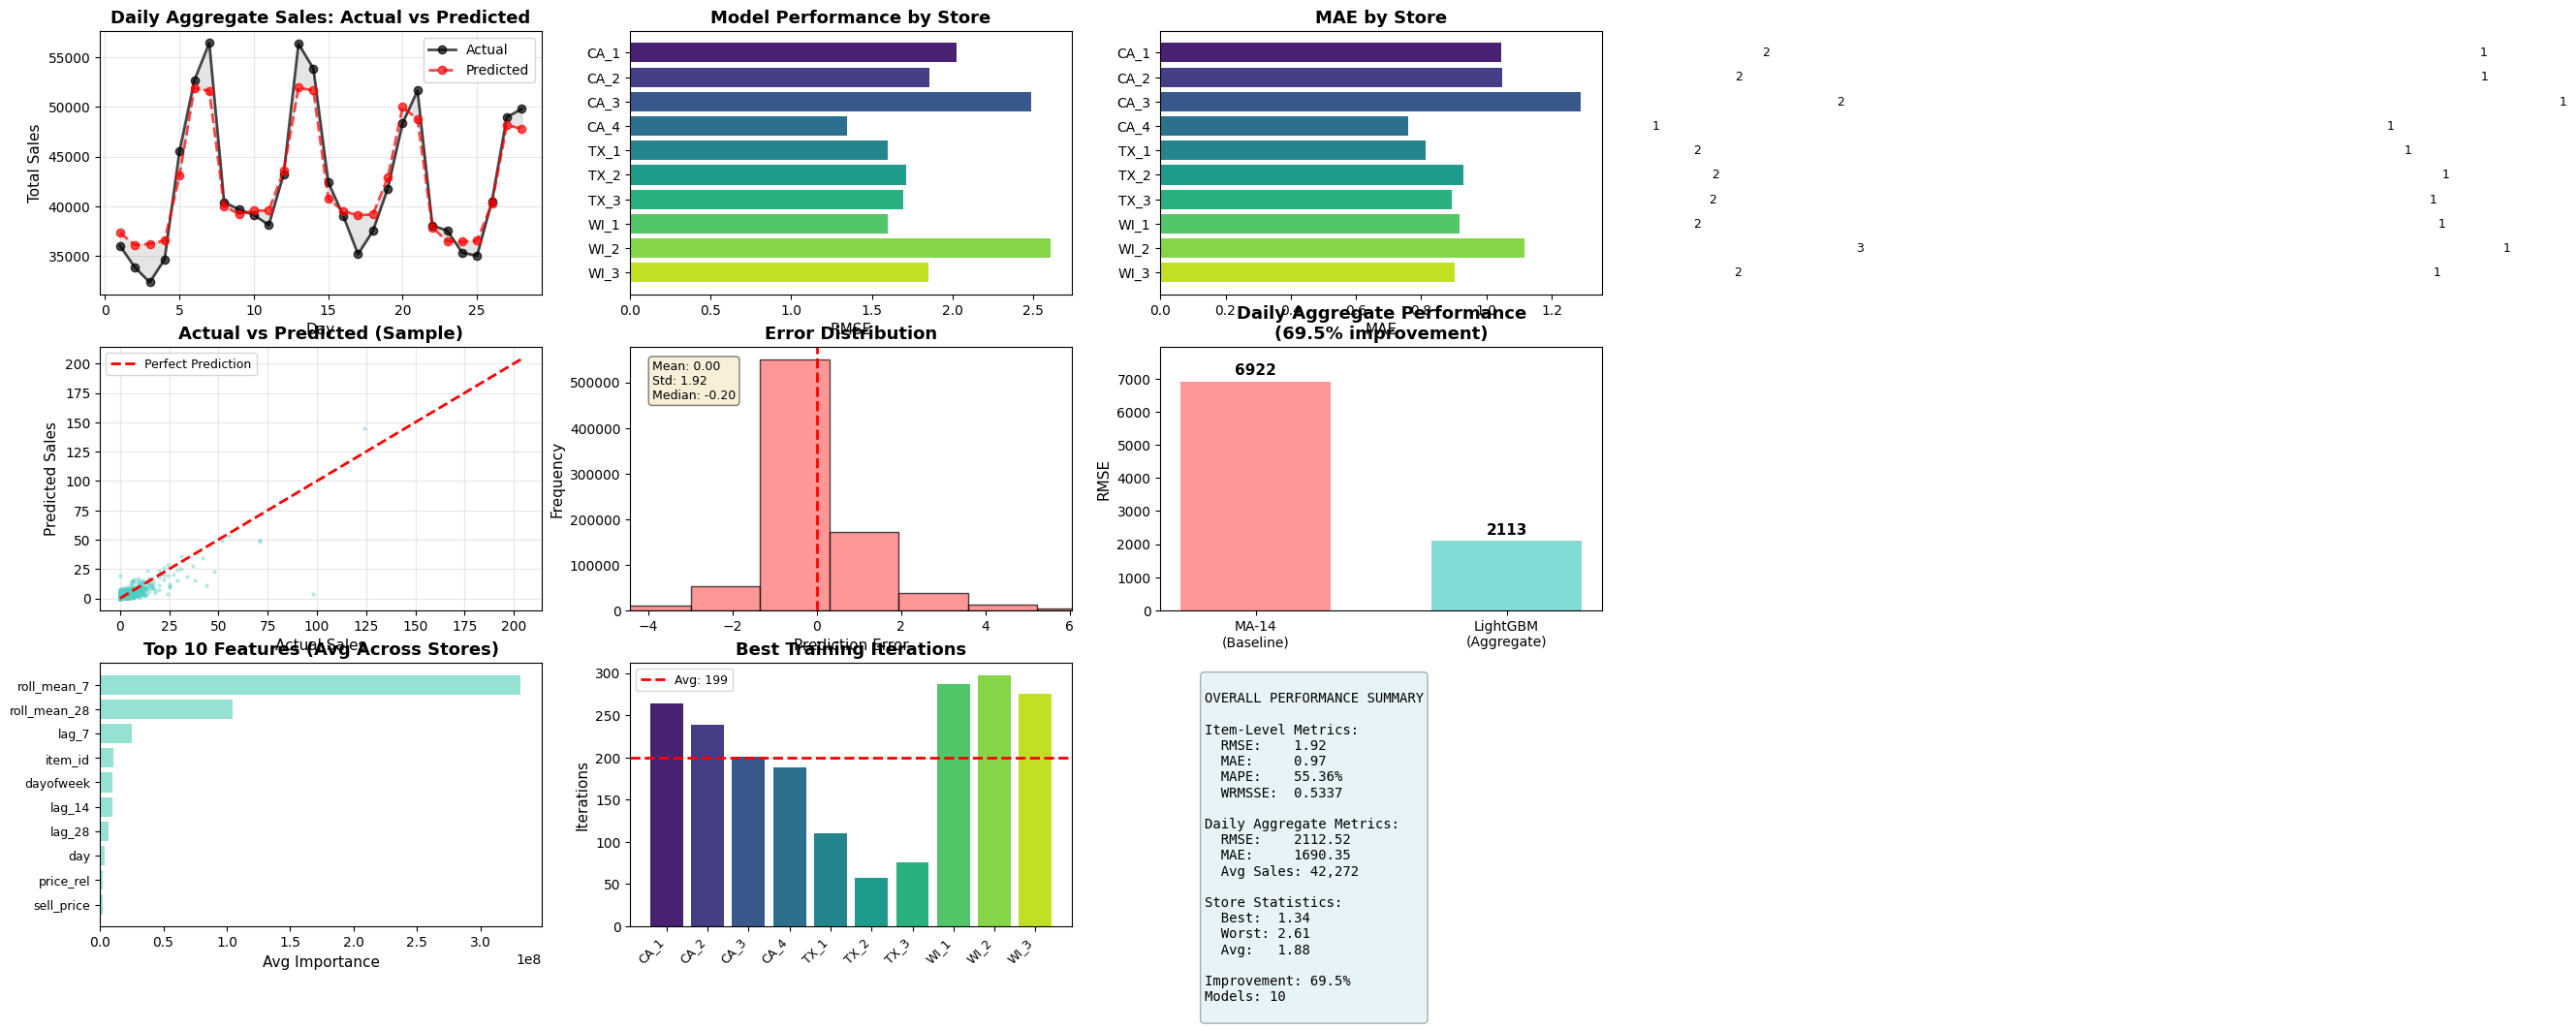

In [ ]:
fig = plt.figure(figsize=(20, 12))

# Plot 1: Daily Aggregate Predictions
ax1 = plt.subplot(3, 3, 1)
days = np.arange(1, VALIDATION_DAYS + 1)
ax1.plot(days, daily_actuals, 'ko-', linewidth=2, markersize=6, label='Actual', alpha=0.7)
ax1.plot(days, daily_predictions, 'ro--', linewidth=2, markersize=6, label='Predicted', alpha=0.7)
ax1.fill_between(days, daily_actuals, daily_predictions, alpha=0.2, color='gray')
ax1.set_xlabel('Day', fontsize=11)
ax1.set_ylabel('Total Sales', fontsize=11)
ax1.set_title('Daily Aggregate Sales: Actual vs Predicted', fontsize=13, weight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: WRMSSE by Store
ax2 = plt.subplot(3, 3, 2)
colors = sns.color_palette("viridis", len(store_results_df))
ax2.barh(store_results_df['Store'], store_results_df['WRMSSE'], color=colors)
ax2.set_xlabel('WRMSSE', fontsize=11)
ax2.set_title('WRMSSE by Store (M5 Metric)', fontsize=13, weight='bold')
ax2.invert_yaxis()
for i, v in enumerate(store_results_df['WRMSSE'].values):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

# Plot 3: R² by Store
ax3 = plt.subplot(3, 3, 3)
ax3.barh(store_results_df['Store'], store_results_df['R_squared'], color=colors)
ax3.set_xlabel('R²', fontsize=11)
ax3.set_title('R² by Store (Higher is Better)', fontsize=13, weight='bold')
ax3.invert_yaxis()
for i, v in enumerate(store_results_df['R_squared'].values):
    ax3.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9)

# Plot 4: Actual vs Predicted Scatter (sample)
ax4 = plt.subplot(3, 3, 4)
sample_size = min(5000, len(all_actuals))
sample_idx = np.random.choice(len(all_actuals), sample_size, replace=False)
ax4.scatter(all_actuals[sample_idx], all_predictions[sample_idx], alpha=0.3, s=5, c='#4ECDC4')
max_val = max(all_actuals.max(), all_predictions.max())
ax4.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax4.set_xlabel('Actual Sales', fontsize=11)
ax4.set_ylabel('Predicted Sales', fontsize=11)
ax4.set_title('Actual vs Predicted (Sample)', fontsize=13, weight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Plot 5: Error Distribution
ax5 = plt.subplot(3, 3, 5)
errors = all_actuals - all_predictions
ax5.hist(errors, bins=100, color='#FF6B6B', alpha=0.7, edgecolor='black')
ax5.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax5.set_xlabel('Prediction Error', fontsize=11)
ax5.set_ylabel('Frequency', fontsize=11)
ax5.set_title('Error Distribution', fontsize=13, weight='bold')
ax5.set_xlim(np.percentile(errors, 1), np.percentile(errors, 99))
ax5.text(0.05, 0.95, f'Mean: {errors.mean():.2f}\nStd: {errors.std():.2f}\nMedian: {np.median(errors):.2f}',
         transform=ax5.transAxes, verticalalignment='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 6: R² Performance Comparison
ax6 = plt.subplot(3, 3, 6)
r2_comparison = [daily_r2]
colors_comp = ['#4ECDC4']
bars = ax6.bar(['LightGBM'], r2_comparison, color=colors_comp, alpha=0.7, width=0.4)
ax6.set_ylabel('R²', fontsize=11)
ax6.set_title('Daily Aggregate R² Performance', fontsize=13, weight='bold')
for bar, val in zip(bars, r2_comparison):
    ax6.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=11, weight='bold')
ax6.set_ylim(0, 1.1)

# Plot 7: Feature Importance (aggregated across stores)
ax7 = plt.subplot(3, 3, 7)
# Calculate average importance across all stores
all_importance = []
for store in stores:
    model = lgb.Booster(model_file=f'model_{store}.txt')
    importance = model.feature_importance(importance_type='gain')
    all_importance.append(importance)
avg_importance = np.mean(all_importance, axis=0)
importance_df = pd.DataFrame({'feature': all_features, 'importance': avg_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(10)
ax7.barh(range(len(importance_df)), importance_df['importance'], color='#95E1D3')
ax7.set_yticks(range(len(importance_df)))
ax7.set_yticklabels(importance_df['feature'], fontsize=9)
ax7.set_xlabel('Avg Importance', fontsize=11)
ax7.set_title('Top 10 Features (Avg Across Stores)', fontsize=13, weight='bold')
ax7.invert_yaxis()

# Plot 8: Training Iterations
ax8 = plt.subplot(3, 3, 8)
ax8.bar(range(len(store_results_df)), store_results_df['Best_Iteration'], color=colors)
ax8.set_xticks(range(len(store_results_df)))
ax8.set_xticklabels(store_results_df['Store'], rotation=45, ha='right', fontsize=9)
ax8.set_ylabel('Iterations', fontsize=11)
ax8.set_title('Best Training Iterations', fontsize=13, weight='bold')
ax8.axhline(y=store_results_df['Best_Iteration'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f"Avg: {store_results_df['Best_Iteration'].mean():.0f}")
ax8.legend(fontsize=9)

# Plot 9: Metrics Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')
summary_text = f"""
OVERALL PERFORMANCE SUMMARY

Item-Level Metrics:
  WRMSSE:       {overall_wrmsse:.4f}
  Weighted MAE: {overall_w_mae:.2f}
  R²:           {overall_r2:.4f}

Daily Aggregate Metrics:
  WRMSSE:       {daily_wrmsse:.4f}
  Weighted MAE: {daily_w_mae:.2f}
  R²:           {daily_r2:.4f}
  Avg Sales:     {daily_actuals.mean():,.0f}

Store R² Statistics:
  Best:  {store_results_df['R_squared'].max():.4f}
  Worst: {store_results_df['R_squared'].min():.4f}
  Avg:   {store_results_df['R_squared'].mean():.4f}

Models: {len(stores)}
"""
ax9.text(0.1, 0.95, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.savefig('lightgbm_aggregate_results.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
store_results_df.to_csv('lightgbm_store_results.csv', index=False)
print("✓ Saved 'lightgbm_store_results.csv'")

# Save aggregate metrics
aggregate_metrics = {
    'Metric': ['Overall_WRMSSE', 'Overall_Weighted_MAE', 'Overall_R_squared',
               'Daily_WRMSSE', 'Daily_Weighted_MAE', 'Daily_R_squared'],
    'Value': [overall_wrmsse, overall_w_mae, overall_r2,
              daily_wrmsse, daily_w_mae, daily_r2]
}
pd.DataFrame(aggregate_metrics).to_csv('lightgbm_aggregate_metrics.csv', index=False)
print("✓ Saved 'lightgbm_aggregate_metrics.csv'")

# Save daily predictions vs actuals
daily_results = pd.DataFrame({
    'Day': range(1, VALIDATION_DAYS + 1),
    'Date': calendar[calendar['d'].isin(day_cols[-VALIDATION_DAYS:])]['date'].values,
    'Actual_Sales': daily_actuals,
    'Predicted_Sales': daily_predictions,
    'Error': daily_actuals - daily_predictions,
    'Error_Pct': ((daily_actuals - daily_predictions) / daily_actuals) * 100
})
daily_results.to_csv('lightgbm_daily_predictions.csv', index=False)
print("✓ Saved 'lightgbm_daily_predictions.csv'")

# Save aggregated feature importance
all_importance = []
for store in stores:
    model = lgb.Booster(model_file=f'model_{store}.txt')
    importance = model.feature_importance(importance_type='gain')
    for feat, imp in zip(all_features, importance):
        all_importance.append({'store': store, 'feature': feat, 'importance': imp})

importance_df = pd.DataFrame(all_importance)
avg_importance = importance_df.groupby('feature')['importance'].agg(['mean', 'std']).sort_values('mean', ascending=False)
avg_importance.to_csv('feature_importance_aggregated.csv')
print("✓ Saved 'feature_importance_aggregated.csv'")

✓ Saved 'lightgbm_store_results.csv'
✓ Saved 'lightgbm_aggregate_metrics.csv'
✓ Saved 'lightgbm_daily_predictions.csv'
✓ Saved 'feature_importance_aggregated.csv'


In [ ]:
# LightGBM: Predicted vs Actual Time Series Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Daily Aggregate - Predicted vs Actual
ax1 = axes[0]
days = np.arange(1, VALIDATION_DAYS + 1)
ax1.plot(days, daily_actuals, 'b-', linewidth=2.5, marker='o', markersize=8, label='Actual Sales', alpha=0.8)
ax1.plot(days, daily_predictions, 'r--', linewidth=2.5, marker='s', markersize=7, label='Predicted Sales', alpha=0.8)
ax1.fill_between(days, daily_actuals, daily_predictions, alpha=0.2, color='purple')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Total Daily Sales', fontsize=12)
ax1.set_title('LightGBM: Daily Aggregate Predicted vs Actual Sales', fontsize=14, weight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(days)

# Add metrics annotation
metrics_text = f'WRMSSE: {daily_wrmsse:.4f}\nWeighted MAE: {daily_w_mae:.2f}\nR²: {daily_r2:.4f}'
ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Scatter plot with regression line
ax2 = axes[1]
ax2.scatter(daily_actuals, daily_predictions, s=100, c='#4ECDC4', alpha=0.7, edgecolors='black', linewidth=1)

# Add perfect prediction line
min_val = min(daily_actuals.min(), daily_predictions.min())
max_val = max(daily_actuals.max(), daily_predictions.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction (y=x)')

# Add regression line
z = np.polyfit(daily_actuals, daily_predictions, 1)
p = np.poly1d(z)
ax2.plot(daily_actuals, p(daily_actuals), 'g-', linewidth=2, label=f'Fitted Line (y={z[0]:.2f}x + {z[1]:.0f})')

ax2.set_xlabel('Actual Daily Sales', fontsize=12)
ax2.set_ylabel('Predicted Daily Sales', fontsize=12)
ax2.set_title('LightGBM: Actual vs Predicted Scatter Plot', fontsize=14, weight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add day labels to points
for i, day in enumerate(days):
    ax2.annotate(f'D{day}', (daily_actuals[i], daily_predictions[i]), 
                 textcoords="offset points", xytext=(5, 5), fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('lightgbm_predicted_vs_actual.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Saved 'lightgbm_predicted_vs_actual.png'")


### N-beats

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc

In [6]:
FORECAST_HORIZON = 28
LOOKBACK_WINDOW = 56  # Use 56 days of history to predict 28 days
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
HIDDEN_SIZE = 128
NUM_BLOCKS = 3
AGGREGATION_LEVEL = 'store_category'  # Aggregate to reduce series count

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
class NBeatsBlock(nn.Module):
    """Single N-BEATS block"""
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        
        # Backcast should match input size, forecast should match output size
        self.theta_b = nn.Linear(hidden_size, input_size)   # Backcast matches input
        self.theta_f = nn.Linear(hidden_size, output_size)  # Forecast matches output
        
    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        h = torch.relu(self.fc3(h))
        h = torch.relu(self.fc4(h))
        
        backcast = self.theta_b(h)  # Shape: (batch, input_size)
        forecast = self.theta_f(h)  # Shape: (batch, output_size)
        
        return backcast, forecast

In [8]:
class NBeatsNet(nn.Module):
    """N-BEATS Network"""
    def __init__(self, input_size, output_size, hidden_size=128, num_blocks=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size, output_size, hidden_size)
            for _ in range(num_blocks)
        ])
        
    def forward(self, x):
        residuals = x  # Start with input (shape: batch, input_size)
        forecast = torch.zeros(x.size(0), self.output_size, device=x.device)
        
        for block in self.blocks:
            block_backcast, block_forecast = block(residuals)
            residuals = residuals - block_backcast  # Both have shape (batch, input_size)
            forecast = forecast + block_forecast     # Both have shape (batch, output_size)
            
        return forecast

In [9]:
class TimeSeriesDataset(Dataset):
    """Time series dataset for N-BEATS"""
    def __init__(self, data, lookback, horizon, train=True):
        self.data = data
        self.lookback = lookback
        self.horizon = horizon
        self.train = train
        
        # Create sequences
        self.X = []
        self.y = []
        
        for i in range(lookback, len(data) - horizon + 1):
            self.X.append(data[i - lookback:i])
            if train:
                self.y.append(data[i:i + horizon])
        
        self.X = np.array(self.X, dtype=np.float32)
        if train:
            self.y = np.array(self.y, dtype=np.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.train:
            return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])
        else:
            return torch.FloatTensor(self.X[idx])

In [11]:
sales = pd.read_csv('/kaggle/input/forecasting-data/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/forecasting-data/calendar.csv')

day_cols = [col for col in sales.columns if col.startswith('d_')]
print(f"✓ Loaded {len(day_cols)} days of data")


✓ Loaded 1913 days of data


In [12]:
def create_aggregated_series(sales_df, level):
    """Aggregate sales to reduce number of series"""
    if level == 'store_category':
        group_cols = ['store_id', 'cat_id']
    elif level == 'store_dept':
        group_cols = ['store_id', 'dept_id']
    elif level == 'category':
        group_cols = ['cat_id']
    elif level == 'store':
        group_cols = ['store_id']
    else:
        raise ValueError(f"Unknown level: {level}")
    
    agg_sales = sales_df.groupby(group_cols)[day_cols].sum().reset_index()
    
    if len(group_cols) > 1:
        agg_sales['series_id'] = agg_sales[group_cols].apply(lambda x: '_'.join(x), axis=1)
    else:
        agg_sales['series_id'] = agg_sales[group_cols[0]]
    
    return agg_sales

agg_sales = create_aggregated_series(sales, AGGREGATION_LEVEL)
n_series = len(agg_sales)

In [ ]:
models = {}
series_results = []

for idx, row in agg_sales.iterrows():
    series_id = row['series_id']
    print(f"\n   [{idx+1}/{n_series}] Training {series_id}...")
    
    # Get time series data
    ts_data = np.array([row[col] for col in day_cols], dtype=np.float32)
    
    # Normalize data
    scaler = StandardScaler()
    ts_data_scaled = scaler.fit_transform(ts_data.reshape(-1, 1)).flatten()
    
    # Split train/validation
    train_data = ts_data_scaled[:-FORECAST_HORIZON]
    val_data = ts_data_scaled
    
    # Create datasets
    train_dataset = TimeSeriesDataset(train_data, LOOKBACK_WINDOW, FORECAST_HORIZON, train=True)
    
    if len(train_dataset) < BATCH_SIZE:
        print(f"      Warning: Not enough data for {series_id}, skipping...")
        continue
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model
    model = NBeatsNet(
        input_size=LOOKBACK_WINDOW,
        output_size=FORECAST_HORIZON,
        hidden_size=HIDDEN_SIZE,
        num_blocks=NUM_BLOCKS
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    model.train()
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        
        if (epoch + 1) % 10 == 0:
            print(f"      Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"      Early stopping at epoch {epoch+1}")
                break
    
    # Validation prediction
    model.eval()
    with torch.no_grad():
        # Use last LOOKBACK_WINDOW days to predict
        last_sequence = torch.FloatTensor(train_data[-LOOKBACK_WINDOW:]).unsqueeze(0).to(device)
        prediction_scaled = model(last_sequence).cpu().numpy().flatten()
    
    # Denormalize
    prediction = scaler.inverse_transform(prediction_scaled.reshape(-1, 1)).flatten()
    prediction = np.maximum(prediction, 0)  # Ensure non-negative
    
    # Get actual values
    actual = ts_data[-FORECAST_HORIZON:]
    
    # Calculate metrics
    wrmsse_val = wrmsse(actual, prediction)
    w_mae = weighted_mae(actual, prediction)
    r2 = r_squared(actual, prediction)
    
    print(f"      ✓ WRMSSE: {wrmsse_val:.4f}, Weighted MAE: {w_mae:.2f}, R²: {r2:.4f}")
    
    # Store results
    models[series_id] = {'model': model, 'scaler': scaler}
    series_results.append({
        'series_id': series_id,
        'WRMSSE': wrmsse_val,
        'Weighted_MAE': w_mae,
        'R_squared': r2,
        'predictions': prediction,
        'actuals': actual
    })
    
    # Clear memory
    del model, train_dataset, train_loader
    torch.cuda.empty_cache()
    gc.collect()


   [1/30] Training CA_1_FOODS...
      Epoch 10/50, Loss: 0.2304
      Epoch 20/50, Loss: 0.2052
      Epoch 30/50, Loss: 0.1811
      Epoch 40/50, Loss: 0.1631
      Epoch 50/50, Loss: 0.1483
      ✓ RMSE: 221.78, MAE: 181.47

   [2/30] Training CA_1_HOBBIES...
      Epoch 10/50, Loss: 0.5028
      Epoch 20/50, Loss: 0.4447
      Epoch 30/50, Loss: 0.3889
      Epoch 40/50, Loss: 0.3218
      Epoch 50/50, Loss: 0.2673
      ✓ RMSE: 100.34, MAE: 80.98

   [3/30] Training CA_1_HOUSEHOLD...
      Epoch 10/50, Loss: 0.1412
      Epoch 20/50, Loss: 0.1336
      Epoch 30/50, Loss: 0.1204
      Epoch 40/50, Loss: 0.1143
      Epoch 50/50, Loss: 0.1086
      ✓ RMSE: 79.19, MAE: 59.67

   [4/30] Training CA_2_FOODS...
      Epoch 10/50, Loss: 0.1699
      Epoch 20/50, Loss: 0.1563
      Epoch 30/50, Loss: 0.1432
      Epoch 40/50, Loss: 0.1478
      Early stopping at epoch 41
      ✓ RMSE: 204.64, MAE: 148.15

   [5/30] Training CA_2_HOBBIES...
      Epoch 10/50, Loss: 0.4433
      Epoch 20/5

In [ ]:
series_results_df = pd.DataFrame([{
    'series_id': r['series_id'],
    'WRMSSE': r['WRMSSE'],
    'Weighted_MAE': r['Weighted_MAE'],
    'R_squared': r['R_squared']
} for r in series_results])

print("\nPer-Series Results:")
print(series_results_df.to_string(index=False))

# Combine all predictions
all_predictions = np.concatenate([r['predictions'] for r in series_results])
all_actuals = np.concatenate([r['actuals'] for r in series_results])

# Daily aggregate
daily_predictions = np.zeros(FORECAST_HORIZON)
daily_actuals = np.zeros(FORECAST_HORIZON)

for r in series_results:
    daily_predictions += r['predictions']
    daily_actuals += r['actuals']

# Calculate metrics
overall_wrmsse = wrmsse(all_actuals, all_predictions)
overall_w_mae = weighted_mae(all_actuals, all_predictions)
overall_r2 = r_squared(all_actuals, all_predictions)

daily_wrmsse = wrmsse(daily_actuals, daily_predictions)
daily_w_mae = weighted_mae(daily_actuals, daily_predictions)
daily_r2 = r_squared(daily_actuals, daily_predictions)

print(f"\n{'='*80}")
print("N-BEATS PERFORMANCE METRICS")
print(f"{'='*80}")

print(f"\n📊 SERIES-LEVEL METRICS ({len(series_results)} series):")
print(f"   WRMSSE:       {overall_wrmsse:.4f}")
print(f"   Weighted MAE: {overall_w_mae:.2f}")
print(f"   R²:           {overall_r2:.4f}")

print(f"\n📊 DAILY AGGREGATE METRICS (28 days):")
print(f"   WRMSSE:       {daily_wrmsse:.4f}")
print(f"   Weighted MAE: {daily_w_mae:.2f}")
print(f"   R²:           {daily_r2:.4f}")
print(f"   Avg Daily Sales (Actual):    {daily_actuals.mean():,.0f} units")
print(f"   Avg Daily Sales (Predicted): {daily_predictions.mean():,.0f} units")


Per-Series Results:
     series_id       rmse        mae
    CA_1_FOODS 221.779892 181.466660
  CA_1_HOBBIES 100.344604  80.977715
CA_1_HOUSEHOLD  79.190620  59.674709
    CA_2_FOODS 204.642441 148.150879
  CA_2_HOBBIES  81.332741  63.325676
CA_2_HOUSEHOLD 163.924576 122.181328
    CA_3_FOODS 501.076080 437.138702
  CA_3_HOBBIES  83.346718  66.456177
CA_3_HOUSEHOLD 170.688400 140.454971
    CA_4_FOODS 106.311394  80.606026
  CA_4_HOBBIES  67.838295  54.436401
CA_4_HOUSEHOLD  64.177002  47.649426
    TX_1_FOODS 202.971283 144.198990
  TX_1_HOBBIES  59.607746  43.547138
TX_1_HOUSEHOLD  86.652061  68.802391
    TX_2_FOODS 255.468124 204.278778
  TX_2_HOBBIES  49.379276  39.606792
TX_2_HOUSEHOLD 141.380386 115.592422
    TX_3_FOODS 236.235046 175.242020
  TX_3_HOBBIES  51.290051  40.124176
TX_3_HOUSEHOLD  95.112923  79.253098
    WI_1_FOODS 243.215912 193.261490
  WI_1_HOBBIES  75.412758  56.415466
WI_1_HOUSEHOLD 106.438446  76.712234
    WI_2_FOODS 434.378204 347.470245
  WI_2_HOBBIES  4

In [ ]:
# N-BEATS: Predicted vs Actual Time Series Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Daily Aggregate - Predicted vs Actual
ax1 = axes[0]
days = np.arange(1, FORECAST_HORIZON + 1)
ax1.plot(days, daily_actuals, 'b-', linewidth=2.5, marker='o', markersize=8, label='Actual Sales', alpha=0.8)
ax1.plot(days, daily_predictions, 'r--', linewidth=2.5, marker='s', markersize=7, label='Predicted Sales', alpha=0.8)
ax1.fill_between(days, daily_actuals, daily_predictions, alpha=0.2, color='purple')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Total Daily Sales', fontsize=12)
ax1.set_title('N-BEATS: Daily Aggregate Predicted vs Actual Sales', fontsize=14, weight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(days)

# Add metrics annotation
metrics_text = f'WRMSSE: {daily_wrmsse:.4f}\nWeighted MAE: {daily_w_mae:.2f}\nR²: {daily_r2:.4f}'
ax1.text(0.02, 0.98, metrics_text, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Plot 2: Scatter plot with regression line
ax2 = axes[1]
ax2.scatter(daily_actuals, daily_predictions, s=100, c='#FF6B6B', alpha=0.7, edgecolors='black', linewidth=1)

# Add perfect prediction line
min_val = min(daily_actuals.min(), daily_predictions.min())
max_val = max(daily_actuals.max(), daily_predictions.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction (y=x)')

# Add regression line
z = np.polyfit(daily_actuals, daily_predictions, 1)
p = np.poly1d(z)
ax2.plot(daily_actuals, p(daily_actuals), 'g-', linewidth=2, label=f'Fitted Line (y={z[0]:.2f}x + {z[1]:.0f})')

ax2.set_xlabel('Actual Daily Sales', fontsize=12)
ax2.set_ylabel('Predicted Daily Sales', fontsize=12)
ax2.set_title('N-BEATS: Actual vs Predicted Scatter Plot', fontsize=14, weight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add day labels to points
for i, day in enumerate(days):
    ax2.annotate(f'D{day}', (daily_actuals[i], daily_predictions[i]), 
                 textcoords="offset points", xytext=(5, 5), fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('nbeats_predicted_vs_actual.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Saved 'nbeats_predicted_vs_actual.png'")


### Sequence2Sequence Models: Informer

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc
import math

In [28]:
FORECAST_HORIZON = 28
LOOKBACK_WINDOW = 56
BATCH_SIZE = 32  # Small batch for memory efficiency
EPOCHS = 30
LEARNING_RATE = 0.0001
D_MODEL = 64  # Model dimension (smaller for 8GB RAM)
N_HEADS = 4
E_LAYERS = 2  # Encoder layers
D_LAYERS = 1  # Decoder layers
D_FF = 128  # Feedforward dimension
DROPOUT = 0.1
AGGREGATION_LEVEL = 'store_category'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
class ProbAttention(nn.Module):
    """ProbSparse Self-Attention (Informer's key innovation)"""
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1):
        super().__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.dropout = nn.Dropout(attention_dropout)
        
    def _prob_QK(self, Q, K, sample_k, n_top):
        """ProbSparse sampling"""
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape
        
        # Sample K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        
        # Calculate Q_K
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)
        
        # Find top queries
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]
        
        return M_top
    
    def forward(self, queries, keys, values):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape
        
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        
        scale = self.scale or 1. / math.sqrt(D)
        
        # For cross-attention (L_Q != L_K), use full attention
        if L_Q != L_K:
            scores = torch.matmul(queries, keys.transpose(-2, -1)) * scale
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            context = torch.matmul(attn, values)
            return context.transpose(1, 2).contiguous()
        
        # For self-attention, use ProbSparse
        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()
        
        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q
        
        # ProbSparse sampling
        scores_top = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)
        
        # Use mean of values as default context for non-selected queries
        V_mean = values.mean(dim=2, keepdim=True).expand(-1, -1, L_Q, -1)
        context = V_mean.clone()
        
        for i in range(B):
            for j in range(H):
                selected_Q = queries[i, j, scores_top[i, j], :]
                attn = torch.matmul(selected_Q, keys[i, j].transpose(-2, -1))
                attn = attn * scale
                attn = F.softmax(attn, dim=-1)
                attn = self.dropout(attn)
                out = torch.matmul(attn, values[i, j])
                context[i, j, scores_top[i, j], :] = out
        
        return context.transpose(1, 2).contiguous()

In [30]:
class AttentionLayer(nn.Module):
    """Attention layer wrapper"""
    def __init__(self, attention, d_model, n_heads, d_keys=None, d_values=None):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        
    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        
        out = self.inner_attention(queries, keys, values)
        out = out.view(B, L, -1)
        
        return self.out_projection(out)

In [31]:
class EncoderLayer(nn.Module):
    """Informer Encoder Layer"""
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        new_x = self.attention(x, x, x)
        x = x + self.dropout(new_x)
        x = self.norm1(x)
        
        y = x
        y = self.dropout(F.relu(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        return self.norm2(x + y)

In [32]:
class DecoderLayer(nn.Module):
    """Informer Decoder Layer"""
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, cross):
        x = x + self.dropout(self.self_attention(x, x, x))
        x = self.norm1(x)
        
        x = x + self.dropout(self.cross_attention(x, cross, cross))
        x = self.norm2(x)
        
        y = x
        y = self.dropout(F.relu(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))
        
        return self.norm3(x + y)

In [33]:
class Encoder(nn.Module):
    """Informer Encoder"""
    def __init__(self, attn_layers, norm_layer=None):
        super().__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer
        
    def forward(self, x):
        for attn_layer in self.attn_layers:
            x = attn_layer(x)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [34]:
class Decoder(nn.Module):
    """Informer Decoder"""
    def __init__(self, layers, norm_layer=None):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        
    def forward(self, x, cross):
        for layer in self.layers:
            x = layer(x, cross)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

In [35]:
class Informer(nn.Module):
    """Complete Informer Model"""
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                 d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=512, 
                 dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu'):
        super().__init__()
        self.pred_len = out_len
        self.label_len = label_len
        self.seq_len = seq_len
        
        # Encoding
        self.enc_embedding = nn.Linear(enc_in, d_model)
        self.dec_embedding = nn.Linear(dec_in, d_model)
        
        # Positional encoding - separate for encoder and decoder
        self.enc_position_encoding = nn.Parameter(torch.randn(1, seq_len, d_model))
        self.dec_position_encoding = nn.Parameter(torch.randn(1, label_len + out_len, d_model))
        
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        ProbAttention(False, attention_dropout=dropout),
                        d_model, n_heads
                    ),
                    d_model, d_ff, dropout=dropout
                ) for _ in range(e_layers)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )
        
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        ProbAttention(True, attention_dropout=dropout),
                        d_model, n_heads
                    ),
                    AttentionLayer(
                        ProbAttention(False, attention_dropout=dropout),
                        d_model, n_heads
                    ),
                    d_model, d_ff, dropout=dropout
                ) for _ in range(d_layers)
            ],
            norm_layer=nn.LayerNorm(d_model)
        )
        
        # Projection
        self.projection = nn.Linear(d_model, c_out, bias=True)
        
    def forward(self, x_enc, x_dec):
        # Encoding
        enc_out = self.enc_embedding(x_enc)
        enc_out = enc_out + self.enc_position_encoding[:, :x_enc.size(1), :]
        enc_out = self.encoder(enc_out)
        
        # Decoding
        dec_out = self.dec_embedding(x_dec)
        dec_out = dec_out + self.dec_position_encoding[:, :x_dec.size(1), :]
        dec_out = self.decoder(dec_out, enc_out)
        dec_out = self.projection(dec_out)
        
        return dec_out[:, -self.pred_len:, :]

In [36]:
class InformerDataset(Dataset):
    """Dataset for Informer with encoder-decoder structure"""
    def __init__(self, data, seq_len, label_len, pred_len, train=True):
        self.data = data
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len
        self.train = train
        
        self.X_enc = []
        self.X_dec = []
        self.y = []
        
        total_len = seq_len + pred_len
        for i in range(len(data) - total_len + 1):
            # Encoder input: historical data
            self.X_enc.append(data[i:i+seq_len])
            
            # Decoder input: last label_len of encoder + zeros for prediction
            dec_input = np.concatenate([
                data[i+seq_len-label_len:i+seq_len],
                np.zeros((pred_len, data.shape[1]))
            ], axis=0)
            self.X_dec.append(dec_input)
            
            # Target: future values
            if train:
                self.y.append(data[i+seq_len:i+seq_len+pred_len])
        
        self.X_enc = np.array(self.X_enc, dtype=np.float32)
        self.X_dec = np.array(self.X_dec, dtype=np.float32)
        if train:
            self.y = np.array(self.y, dtype=np.float32)
    
    def __len__(self):
        return len(self.X_enc)
    
    def __getitem__(self, idx):
        if self.train:
            return (torch.FloatTensor(self.X_enc[idx]), 
                    torch.FloatTensor(self.X_dec[idx]), 
                    torch.FloatTensor(self.y[idx]))
        else:
            return (torch.FloatTensor(self.X_enc[idx]), 
                    torch.FloatTensor(self.X_dec[idx]))


In [37]:
sales = pd.read_csv('/kaggle/input/forecasting-data/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/forecasting-data/calendar.csv')

day_cols = [col for col in sales.columns if col.startswith('d_')]

In [38]:
def create_aggregated_series(sales_df, level):
    if level == 'store_category':
        group_cols = ['store_id', 'cat_id']
    elif level == 'store':
        group_cols = ['store_id']
    elif level == 'category':
        group_cols = ['cat_id']
    else:
        raise ValueError(f"Unknown level: {level}")
    
    agg_sales = sales_df.groupby(group_cols)[day_cols].sum().reset_index()
    
    if len(group_cols) > 1:
        agg_sales['series_id'] = agg_sales[group_cols].apply(lambda x: '_'.join(x), axis=1)
    else:
        agg_sales['series_id'] = agg_sales[group_cols[0]]
    
    return agg_sales

agg_sales = create_aggregated_series(sales, AGGREGATION_LEVEL)
n_series = len(agg_sales)

In [ ]:
models = {}
series_results = []

LABEL_LEN = FORECAST_HORIZON // 2  # Half of pred_len for label_len

for idx, row in agg_sales.iterrows():
    series_id = row['series_id']
    print(f"\n   [{idx+1}/{n_series}] Training {series_id}...")
    
    # Get time series
    ts_data = np.array([row[col] for col in day_cols], dtype=np.float32)
    
    # Normalize
    scaler = StandardScaler()
    ts_data_scaled = scaler.fit_transform(ts_data.reshape(-1, 1))
    
    # Split train/val
    train_data = ts_data_scaled[:-FORECAST_HORIZON]
    val_data = ts_data_scaled
    
    # Create datasets
    train_dataset = InformerDataset(
        train_data, LOOKBACK_WINDOW, LABEL_LEN, FORECAST_HORIZON, train=True
    )
    
    if len(train_dataset) < BATCH_SIZE:
        print(f"      Warning: Not enough data for {series_id}, skipping...")
        continue
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model
    model = Informer(
        enc_in=1, dec_in=1, c_out=1,
        seq_len=LOOKBACK_WINDOW,
        label_len=LABEL_LEN,
        out_len=FORECAST_HORIZON,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        e_layers=E_LAYERS,
        d_layers=D_LAYERS,
        d_ff=D_FF,
        dropout=DROPOUT
    ).to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    model.train()
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(EPOCHS):
        epoch_loss = 0
        for batch_x_enc, batch_x_dec, batch_y in train_loader:
            batch_x_enc = batch_x_enc.to(device)
            batch_x_dec = batch_x_dec.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x_enc, batch_x_dec)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        
        if (epoch + 1) % 5 == 0:
            print(f"      Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"      Early stopping at epoch {epoch+1}")
                break
    
    # Validation prediction
    model.eval()
    with torch.no_grad():
        # Create validation input
        val_enc = torch.FloatTensor(train_data[-LOOKBACK_WINDOW:]).unsqueeze(0).to(device)
        val_dec = torch.FloatTensor(
            np.concatenate([
                train_data[-LABEL_LEN:],
                np.zeros((FORECAST_HORIZON, 1))
            ], axis=0)
        ).unsqueeze(0).to(device)
        
        prediction_scaled = model(val_enc, val_dec).cpu().numpy().squeeze()
    
    # Denormalize
    prediction = scaler.inverse_transform(prediction_scaled.reshape(-1, 1)).flatten()
    prediction = np.maximum(prediction, 0)
    
    # Get actual values
    actual = ts_data[-FORECAST_HORIZON:]
    
    # Calculate metrics
    wrmsse_val = wrmsse(actual, prediction)
    w_mae = weighted_mae(actual, prediction)
    r2 = r_squared(actual, prediction)
    
    print(f"      ✓ WRMSSE: {wrmsse_val:.4f}, Weighted MAE: {w_mae:.2f}, R²: {r2:.4f}")
    
    # Store results
    models[series_id] = {'model': model, 'scaler': scaler}
    series_results.append({
        'series_id': series_id,
        'WRMSSE': wrmsse_val,
        'Weighted_MAE': w_mae,
        'R_squared': r2,
        'predictions': prediction,
        'actuals': actual
    })
    
    # Clear memory
    del model, train_dataset, train_loader
    torch.cuda.empty_cache()
    gc.collect()


   [1/30] Training CA_1_FOODS...
      Epoch 5/30, Loss: 0.6860
      Epoch 10/30, Loss: 0.3279
      Epoch 15/30, Loss: 0.3037
      Epoch 20/30, Loss: 0.2924
      Epoch 25/30, Loss: 0.2855
      Epoch 30/30, Loss: 0.2785
      ✓ RMSE: 234.46, MAE: 185.62

   [2/30] Training CA_1_HOBBIES...
      Epoch 5/30, Loss: 0.7318
      Epoch 10/30, Loss: 0.6859
      Epoch 15/30, Loss: 0.5812
      Epoch 20/30, Loss: 0.5618
      Epoch 25/30, Loss: 0.5521
      Epoch 30/30, Loss: 0.5450
      ✓ RMSE: 93.17, MAE: 73.75

   [3/30] Training CA_1_HOUSEHOLD...
      Epoch 5/30, Loss: 0.4769
      Epoch 10/30, Loss: 0.2020
      Epoch 15/30, Loss: 0.1736
      Epoch 20/30, Loss: 0.1658
      Epoch 25/30, Loss: 0.1602
      Epoch 30/30, Loss: 0.1556
      ✓ RMSE: 93.13, MAE: 69.99

   [4/30] Training CA_2_FOODS...
      Epoch 5/30, Loss: 0.5268
      Epoch 15/30, Loss: 0.2356
      Epoch 20/30, Loss: 0.2143
      Epoch 25/30, Loss: 0.2033
      Epoch 30/30, Loss: 0.1953
      ✓ RMSE: 420.40, MAE: 3